<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Read-all-stations" data-toc-modified-id="Read-all-stations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read all stations</a></span><ul class="toc-item"><li><span><a href="#Read-all-data" data-toc-modified-id="Read-all-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read all data</a></span></li></ul></li><li><span><a href="#Write-backup" data-toc-modified-id="Write-backup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Write backup</a></span></li><li><span><a href="#Load-backup" data-toc-modified-id="Load-backup-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load backup</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Data-quality-control" data-toc-modified-id="Data-quality-control-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Data quality control</a></span><ul class="toc-item"><li><span><a href="#Apply-all-limits-to-all-variables" data-toc-modified-id="Apply-all-limits-to-all-variables-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Apply all limits to all variables</a></span></li><li><span><a href="#Stuck-values" data-toc-modified-id="Stuck-values-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Stuck values</a></span></li></ul></li><li><span><a href="#Data-statistics" data-toc-modified-id="Data-statistics-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Data statistics</a></span></li></ul></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#Period-plots" data-toc-modified-id="Period-plots-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Period plots</a></span></li><li><span><a href="#Quickly-do-daily-averages-compare" data-toc-modified-id="Quickly-do-daily-averages-compare-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Quickly do daily averages compare</a></span></li><li><span><a href="#Bivariate-polar-plots" data-toc-modified-id="Bivariate-polar-plots-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Bivariate polar plots</a></span></li></ul></li><li><span><a href="#GJA-analysis" data-toc-modified-id="GJA-analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>GJA analysis</a></span></li><li><span><a href="#Check-compliance" data-toc-modified-id="Check-compliance-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Check compliance</a></span><ul class="toc-item"><li><span><a href="#Jabavu" data-toc-modified-id="Jabavu-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Jabavu</a></span></li><li><span><a href="#Diepkloof" data-toc-modified-id="Diepkloof-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Diepkloof</a></span></li><li><span><a href="#Springs" data-toc-modified-id="Springs-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Springs</a></span></li><li><span><a href="#Olifantsfontein" data-toc-modified-id="Olifantsfontein-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Olifantsfontein</a></span></li></ul></li></ul></div>

# Import libraries

In [5]:
# The pandas data science library that gives the 'spreadsheet'-like capabilities to python
import pandas as pd
# The matplotlip library is used to visualize data
import matplotlib.pyplot as plt
import matplotlib as mpl
# The pathlib library is used to manage access to disk. It helps us to keep things the same between Windows and Linux
from pathlib import Path
# The os library is used to list and access files and directories on the hard drive
import os, sys
# Numpy is the numerical library. It is used by many of the ones before, but we import it for in case
import numpy as np
# From Numpy we also import the nan 'missing-value' object that we use alot
from numpy import nan
# For fancy matching of strings, we use re
import re
# String libary for temporary file import
from io import StringIO
# Create tooltips for interactive plots
import mpld3
# For connecting to google sheet
import gspread
from oauth2client.service_account import ServiceAccountCredentials

import xlrd

import datetime 

from scipy import interpolate
from windrose import WindroseAxes
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import seaborn as sns
sns.set_theme(style="darkgrid")

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

https://docs.google.com/spreadsheets/d/1_SjistxWekMyf_w59pu5vHDrhOfmeHLurB47mfq_ahM/edit?usp=sharing

In [6]:
# Configure the connection 
scope = ['https://spreadsheets.google.com/feeds']

# Give the path to the Service Account Credential json file 
# 1. Go to Google Development Console (https://console.developers.google.com/project)
# 2. Create new project
# 3. Go to “APIs & Services > Credentials” and choose “Create credentials > Service account key”.
# 4. Fill out the form
# 5. Click “Create key”
# 6. Select “JSON” and click “Create”

credentials = ServiceAccountCredentials.from_json_keyfile_name('/home/roelof/jupyter/key/crgprojects-b66f872bd816.json',
                                                               scope)
# Authorise your Notebook
gc = gspread.authorize(credentials)

# The sprad sheet ID, which can be taken from the link to the sheet
spreadsheet_key = '1_SjistxWekMyf_w59pu5vHDrhOfmeHLurB47mfq_ahM'


#Opening the worksheet by using Worksheet ID
def readSheet():
    workbook = gc.open_by_key(spreadsheet_key)#Selecting which sheet to pulling the data
    stations = workbook.worksheet('Overview')#Pulling the data and transform it to the data frame
    values = stations.get_all_values()
    Stations = pd.DataFrame(values[1:], columns=values[0])
    return(stations,Stations)
stations, Stations = readSheet()

In [7]:
def head(filename,N=10):
    n=0
    with open(Path(filename)) as fp:
        for l in fp.readlines():
            if n<N:
                print(l,end="")
                n=n+1
                
def tail(filename,N=10):
    n=0
    with open(Path(filename)) as fp:
        lines=[i for i in fp.readlines()]
        Nlines=len(lines)
        for l in lines[Nlines-N:]:
            if n<N:
                print(l,end="")
                n=n+1
                
def ConvertNumeric(df,var):
    df[var]= pd.to_numeric(df[var],errors='coerce')
    
def testLogger(filename):
    Sep=","
    Data=[]
    with open(filename) as fp:
        for line in fp.readlines():
            row=line.split(Sep)
            Data.append(len(row))
    print(pd.DataFrame({"Columns":Data}).describe())
    
def ncolumnsLogger(filename):
    Sep=","
    Data=[]
    with open(filename) as fp:
        for line in fp.readlines():
            row=line.split(Sep)
            Data.append(len(row))
    return(np.median(np.array(Data)))

def readLogger(filename, nLines=18):
    DataString=""
    Sep=","
    with open(filename) as fp:
        for line in fp.readlines():
            row=line.split(Sep)
            if isinstance(nLines, list):
                if len(row) in nLines and re.match('\W*(\d{4})[/.-](\d{2})[/.-](\d{2})\s{1}(\d{2}):(\d{2}):(\d{2})\W*',row[0]):
                    DataString=DataString+line                
            else:
                if len(row) == nLines and re.match('\W*(\d{4})[/.-](\d{2})[/.-](\d{2})\s{1}(\d{2}):(\d{2}):(\d{2})\W*',row[0]):
                    DataString=DataString+line
    return(DataString)

def readRM(filename, nLines=18):
    DataString=""
    Sep=","
    with open(filename) as fp:
        for line in fp.readlines():
            row=line.split(Sep)
            if len(row) == nLines and re.match('\W*(\d{4})[/.-](\d{2})[/.-](\d{2})\s{1}(\d{2}):(\d{2}):(\d{2})\W*',row[0]):
                DataString=DataString+line
    return(DataString)

def lsR(dir,pattern=".csv",prefix="",postfix=""):
    list=[]
    for path,dirs,files in os.walk(Path(dir)):
        for f in files:
            if f.count(pattern) > 0 and f.startswith(prefix) and f.endswith(postfix):
                list.append(os.path.join(path,f))
    return(list)

def clearplots():
    plt.clf()

In [8]:
def plotdiurnalstats(df,var='PM10_logger (ug/m3)'):
    df['Time'] = df.index.map(lambda x: x.strftime("%H:00"))
    diurnal = df[['Time',var]].groupby('Time').describe()[var]
    fig, ax = plt.subplots(1, figsize=(7,6))
    ax.set_ylabel(var, fontsize=14, weight='bold')                                                                                                                                                                                                                           
    ax.set_xlabel('Time of Day', fontsize=14)                                                                                                                                                                                                                                    
    print("Plotting mean")                                                                                                                                                                                                                                                       
    ax.plot(diurnal.index, diurnal['50%'], 'g', linewidth=2.0,label=var)
    print("Plotting 75%")                                                                                                                                                                                                                                                        
    ax.plot(diurnal.index, diurnal['75%'], color='g')                                                                                                                                                                                                                            
    print("Plotting 25%")                                                                                                                                                                                                                                                        
    ax.plot(diurnal.index, diurnal['25%'], color='g') 
    ax.fill_between(diurnal.index, diurnal['50%'], diurnal['75%'], alpha=.25, facecolor='g')                                                                                                                                                                                      
    ax.fill_between(diurnal.index, diurnal['50%'], diurnal['25%'], alpha=.25, facecolor='g') 
    ax.set_xlim(0, 23);                                                                                                                                                                                                                                                          
    ax.set_xticks([i for i in range(0,24,3)])  
    plt.tight_layout() 
    
def plotdiurnal(df,var=''):
    df['decimalhour'] = df.index.hour+(df.index.minute/60)
    
    fig, ax = plt.subplots(figsize=(7,6))
    ax.set_ylabel(var, fontsize=14, weight='bold')                                                                                                                                                                                                                           
    ax.set_xlabel('Time of Day', fontsize=14)    
    
    ax.plot(df['decimalhour'].values, df[var].values, 'o', markersize=2, linewidth=0, label=var, alpha=0.3)

    #def format_coord(x, y):
    #    z=np.array_str(df[(df['decimalhour']==x)&(df[var]==y)].index.map(lambda x: x.strftime("%y/%m/%d %H:%M")).values)[1:34]
    #    return('x={}, y={}, date={}'%(x, y,z))

    #ax.format_coord = format_coord
    
    ax.set_xlim(0, 23);                                                                                                                                                                                                                                                          
    ax.set_xticks([i for i in range(0,24,3)])  
    plt.tight_layout() 
    df=df.drop(['decimalhour'], axis = 1)
    
def plottimeseries(df,var=''):
    fig, ax = plt.subplots(1,figsize=(7,6))
    df[[var]].plot(ax=ax)
    ax.set_ylabel(var, fontsize=14, weight='bold')                                                                                                                                                                                                                           
    ax.set_xlabel('', fontsize=14)

In [9]:
# This 'widget' is used to give us interactive graph capabilities in the matplotlib figures
%matplotlib widget

In [10]:
HomeDir=Path('/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/')

In [11]:
os.listdir(HomeDir)

['20211018',
 'SAAQIS_Metadata.csv',
 '20210101',
 'SA_PM_monitoring network.xlsx']

In [12]:
HomeDir=Path('/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018')

In [13]:
# Default function to read data format from SAAQIS database
def custom_date_parser(time):
    NoDates=['Max Date', 'Max Time', 'Minimum', 'Min Date', 'Min Time','Avg','Std','Data Percent','Num', 'Maximum']
    if time not in NoDates:
        try:
            time = datetime.datetime.strptime(time, "%H:%M %d/%m/%Y")
        except ValueError:
            time = time.replace('24:', '23:')
            time = datetime.datetime.strptime(time, "%H:%M %d/%m/%Y")
            time += datetime.timedelta(hours=1)
        except:
            return(np.nan)
        return(time)

# Read all stations

In [14]:
HomeDir

PosixPath('/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018')

In [15]:
os.listdir('/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20210101')

['GP',
 'FS',
 'MP',
 'DEFF',
 'Limpopo',
 'EC',
 'WC',
 'NW',
 'SASOL',
 'Eskom',
 'SAWS',
 'KZN',
 'NC']

In [16]:
os.listdir(HomeDir)

['Gauteng', 'Mpumalanga', 'Limpopo', 'SAAQIS_raw.csv', 'North_West']

In [17]:
import re
string = 'abcd1234efg567'
newstring = re.sub(r'[0-9]+', '', string)
print(newstring)


abcdefg


In [18]:
lsR(HomeDir / '20210101', 'xlsx')

[]

In [19]:
lsR(HomeDir , 'xlsx')

['/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_CO_2017_2018.xlsx',
 '/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_NO2_2018_2019.xlsx',
 '/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_NO_2019_2020.xlsx',
 '/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_AmbRelH_2017.xlsx',
 '/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_CO_2016_2017.xlsx',
 '/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_Amb WDirection_2016.xlsx',
 '/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_PM10_2016_2017.xlsx',
 '/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_Amb WDirection_2020.xlsx',
 '/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_AmbRelH_2021.xlsx',
 '/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_PM2.5_2016_2017.xlsx',
 '/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA

In [20]:
DiskStations={}
for s in lsR('/home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20210101', 'xlsx'):
    station=s.split('/')[-1][:-5]
    station = re.sub(r'[0-9| ]+', '', station)
    authority=s.split('/')[-2]
    if s not in DiskStations.keys():
        DiskStations[station]=authority

for s in DiskStations:
    print(s,DiskStations[s])
DiskStations

PTAWest Tshwane
ekandustria Tshwane
booysens Tshwane
mamelodi Tshwane
Hammanskraal Tshwane
bodibeng Tshwane
rosslyn Tshwane
olievenhoutbosch Tshwane
tshwanemarket Tshwane
rebecca_diepkloof_data DEFF
kliprivier DEFF
diepkloof DEFF
sebokeng DEFF
threerivers DEFF
sharpeville DEFF
diepkloof_pm.bigger DEFF
meyerton Sedibeng
vanderbijlpark Sedibeng
nwuvaalcampus NWU
mogalecity Westrand
Moonies Westrand
randfontein Westrand
wattville Ekurhuleni
springs Ekurhuleni
olifantsfontein Ekurhuleni
thokoza Ekurhuleni
tsakane Ekurhuleni
bedfordview Ekurhuleni
tembisa Ekurhuleni
etwatwa Ekurhuleni
Randwater Eskom
alex CoJ
ivorypark CoJ
diepsloot CoJ
jabavu CoJ
orangefarm CoJ
newtown CoJ
buccleugh CoJ
deltapark CoJ
zamdela DEFF
bonganimabasoecopark SASOL
leitrim SASOL
ajjacobs SASOL
pelonomi Mangaung
balfour MP
middelburg DEFF
emalahleni MP
delmas MP
standerton MP
mhluzi steve tshwete
ermelo DEFF
hendrina DEFF
secunda DEFF
witbank DEFF
embalenhlenorth SASOL
bosjesspruit SASOL
embalenhle SASOL
club SASOL


{'PTAWest': 'Tshwane',
 'ekandustria': 'Tshwane',
 'booysens': 'Tshwane',
 'mamelodi': 'Tshwane',
 'Hammanskraal': 'Tshwane',
 'bodibeng': 'Tshwane',
 'rosslyn': 'Tshwane',
 'olievenhoutbosch': 'Tshwane',
 'tshwanemarket': 'Tshwane',
 'rebecca_diepkloof_data': 'DEFF',
 'kliprivier': 'DEFF',
 'diepkloof': 'DEFF',
 'sebokeng': 'DEFF',
 'threerivers': 'DEFF',
 'sharpeville': 'DEFF',
 'diepkloof_pm.bigger': 'DEFF',
 'meyerton': 'Sedibeng',
 'vanderbijlpark': 'Sedibeng',
 'nwuvaalcampus': 'NWU',
 'mogalecity': 'Westrand',
 'Moonies': 'Westrand',
 'randfontein': 'Westrand',
 'wattville': 'Ekurhuleni',
 'springs': 'Ekurhuleni',
 'olifantsfontein': 'Ekurhuleni',
 'thokoza': 'Ekurhuleni',
 'tsakane': 'Ekurhuleni',
 'bedfordview': 'Ekurhuleni',
 'tembisa': 'Ekurhuleni',
 'etwatwa': 'Ekurhuleni',
 'Randwater': 'Eskom',
 'alex': 'CoJ',
 'ivorypark': 'CoJ',
 'diepsloot': 'CoJ',
 'jabavu': 'CoJ',
 'orangefarm': 'CoJ',
 'newtown': 'CoJ',
 'buccleugh': 'CoJ',
 'deltapark': 'CoJ',
 'zamdela': 'DEFF',
 

In [21]:
#pd.Series(data=Stations, name='Stations')

In [22]:
#help(pd.DataFrame)

## Read all data

In [23]:
def readStation(file, authority, var):
    # Read the data file
    df=pd.read_excel(file,
                     skiprows=[0,1,3,4], 
                     parse_dates=[0], 
                     date_parser=custom_date_parser, 
                     index_col=0, 
                     na_values=['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan','1.#IND','1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 'NaN', 'n/a','nan', 'null','-999.0']
                    )
    df.index.name='Date'
    # Remove lines with a bad date index
    df=df.loc[~df.index.isnull()]
    # Remove lines where all data is missing
    df=df.dropna(axis=0, how='all')
    # Make sure that the variables are numeric
    df=df.apply(pd.to_numeric, errors='ignore')
    # Create short version
    df=df.stack()
    df=df.reset_index(level=[1])
    df.columns=['Site','Value']
    df['Variable']=var
    df['Unit']='ppm'
    df['Status']=0
    df['Authority']=authority
    df=df.reset_index()
    df=df.set_index((df.Site + df.Variable + df.Unit + df.Date.astype(str) + df.Value.astype(str)).apply(hash))
    return(df)

In [24]:
#help(pd.read_excel)

In [25]:
FixVars={'Wdir':'WDir',
        'AmbRelH':'RH', 
        'Amb WDirection':'WindDir',
        'SolRad':'SolarRadiation',
        'Amb WSpeed':'WindSpeed',
        'AmbTemp':'Temperature'}
dfRaw = pd.DataFrame() 
for f in lsR(HomeDir, 'xlsx'):
    Filename=f.split('/')[-1]
    Authority=Filename.split('_')[0]
    Variable=Filename.split('_')[1]
    print(Authority,Variable,Filename,f)
    dftmp=readStation(f,Authority,Variable)
    dfRaw=pd.concat([dfRaw,dftmp])
dfRaw['Variable']=dfRaw['Variable'].replace(FixVars, regex=True)

GJA CO GJA_CO_2017_2018.xlsx /home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_CO_2017_2018.xlsx
GJA NO2 GJA_NO2_2018_2019.xlsx /home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_NO2_2018_2019.xlsx
GJA NO GJA_NO_2019_2020.xlsx /home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_NO_2019_2020.xlsx
GJA AmbRelH GJA_AmbRelH_2017.xlsx /home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_AmbRelH_2017.xlsx
GJA CO GJA_CO_2016_2017.xlsx /home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_CO_2016_2017.xlsx
GJA Amb WDirection GJA_Amb WDirection_2016.xlsx /home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_Amb WDirection_2016.xlsx
GJA PM10 GJA_PM10_2016_2017.xlsx /home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_PM10_2016_2017.xlsx
GJA Amb WDirection GJA_Amb WDirection_2020.xlsx /home/roelof/Dropbox (NWU)/CRG_Data/SAAQIS_Data/20211018/Gauteng/GJA_Amb WDirection_2020.xlsx
GJA Am

KeyboardInterrupt: 

In [108]:
FixVars={'Wdir':'WDir',
        'AmbRelH':'RH', 
        'Amb WDirection':'WindDir',
        'SolRad':'SolarRadiation',
        'Amb WSpeed':'WindSpeed',
        'AmbTemp':'Temperature'}
dfRaw['Variable']=dfRaw['Variable'].replace(FixVars, regex=True)

In [109]:
help(dfRaw['Variable'].str.replace)

Help on method replace in module pandas.core.strings.accessor:

replace(pat: 'str | re.Pattern', repl: 'str | Callable', n: 'int' = -1, case: 'bool | None' = None, flags: 'int' = 0, regex: 'bool | None' = None) method of pandas.core.strings.accessor.StringMethods instance
    Replace each occurrence of pattern/regex in the Series/Index.
    
    Equivalent to :meth:`str.replace` or :func:`re.sub`, depending on
    the regex value.
    
    Parameters
    ----------
    pat : str or compiled regex
        String can be a character sequence or regular expression.
    repl : str or callable
        Replacement string or a callable. The callable is passed the regex
        match object and must return a replacement string to be used.
        See :func:`re.sub`.
    n : int, default -1 (all)
        Number of replacements to make from start.
    case : bool, default None
        Determines if replace is case sensitive:
    
        - If True, case sensitive (the default if `pat` is a string

In [110]:
Sites=dfRaw['Site'].unique()
Variables=dfRaw['Variable'].unique()
Sites.sort()

In [111]:
Variables

array(['CO', 'NO2', 'NO', 'RH', 'WindDir', 'PM10', 'PM2.5',
       'SolarRadiation', 'O3', 'WindSpeed', 'Temperature', 'NOx', 'SO2',
       'WSpeed', 'SRad', 'WDir', 'Temp'], dtype=object)

In [112]:
dfRaw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17133756 entries, 2190498970414666113 to 2673592073791924475
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Date       datetime64[ns]
 1   Site       object        
 2   Value      float64       
 3   Variable   object        
 4   Unit       object        
 5   Status     int64         
 6   Authority  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.0+ GB


In [113]:
for v in Variables:
    dftmp=dfRaw[(dfRaw['Variable']==v)&(dfRaw['Status']==0)]
    print(v,dftmp['Value'].min(),dftmp['Value'].mean(),dftmp['Value'].max())

CO -982.333 1.0764385783889987 1719.336
NO2 -982.017 14.772773723825052 1999998.0
NO -982.328 14.219048855361276 1999998.0
RH -981.7 54.86097083665307 250044.72
WindDir 0.0 165.24235932311535 360.0
PM10 -15112.66 61.25016485564989 666667.126
PM2.5 -1554.124 27.096234567072788 399999.6
SolarRadiation -982.38 195.0294255837433 250333.7
O3 -981.833 29.620464432283605 666733.333
WindSpeed -982.35 4.540857894978094 250001.62
Temperature -982.17 18.268934927544212 166697.0
NOx -981.917 24.317960393625192 1999998.0
SO2 -66305.293 8.334168928255243 666673.833
WSpeed -0.05 1.8531684830025856 114.73
SRad -1.05 206.8467777158903 1655.32
WDir 0.0 149.64005439560265 360.0
Temp -752.0 22.744673567963176 1434.3


In [140]:
Stations

,Station_SAAQIS_Name,Station_Name,Type,Owner,Location,Province,District,Latitude,Longitude,Height
0,Algoa park Clinic,Algoa Park Clinic,Residential - Medium/Upper income,Nelson Mandela Metropolitan,Algoa Park residential area,Eastern Cape,Nelson Mandela Bay Metro,-33.901361,25.564167,0
1,Mobile,Mobile,Residential - Low Income,Buffalo City Metropolitan,"Gompo Clinic, East London",Eastern Cape,Buffalo City Metro,-33.014944,27.849248,0
2,Motherwell,Motherwell,Residential - Low Income,Coega Development Corporation,Ikamvelihle township,Eastern Cape,Nelson Mandela Bay Metro,-33.795488,25.616957,0
3,Motherwell Day Hospital,Motherwell Day Hospital,Residential - Medium/Upper Income,Nelson Mandela Metropolitan,Motherwell Day Hospital,Eastern Cape,Nelson Mandela Bay Metro,-33.811066,25.597658,54
4,Saltworks - NAQI,Saltworks - NAQI,Traffic - Street Canyon,Coega Development Corporation,Coega Special Economic Zone (SEZ),Eastern Cape,Nelson Mandela Bay Metro,-33.763778,25.683428,46
...,...,...,...,...,...,...,...,...,...,...
183,City Hall,City Hall,Traffic - Roadside,City of Cape Town,"Cape Town city hall (CBD), Darling Street",WesternCape,Cape Town,-33.9253,18.4238393,0
184,Drill Hall,,,,,,Cape Town,-33.9259,18.4246681,
185,Ferndale,,,,,,eThekwini,-29.7779,30.22211,
186,Jacobs Air Monitoring,,,,,,eThekwini,-29.9317,30.976995,


In [115]:
# Rename stations
for idx,row in Stations[Stations['Station_SAAQIS_Name']!=Stations['Station_Name']][['Station_SAAQIS_Name','Station_Name']].iterrows():
    dfRaw['Site']=dfRaw['Site'].replace(row['Station_SAAQIS_Name'],row['Station_Name'])
    print(row['Station_Name'])

Algoa Park Clinic
Mobile
Walmer - NAQI
East London
AJ_Jacobs
Bayswater_Clinic
Eco_Park
Kagisanong
Pelonomi
Zamdela_NWU
Zamdela
Alexandra
Bedfordview
Bodibeng
Buccleugh
Diepkloof
Etwatwa
Germiston
Ivory_park
Jabavu
Leondale_City
Mogale_City
NWU_Vaal
Olievenhoutbosch
Olifantsfontein
Orange_Farm
PTA_West
Rosslyn
Springs-new
Springs
Tswane_Market
Vanderbijlpark
eNseleni-RBCAA
RBCAA_Airport
City Hall - Durban - NAQI
Ganges

New Castle
Pietermaritzburg -KZN
Pietermaritzburg airport - ORIBI
Settlers - NAQI
Warwick
Wentworth Resevoir
Lephalale
Phalaborwa
PMC_Station_2
PMC_Station_6
PMC_Station_9
Chicken_Farm
Club
Delmas
Elandsfontein
eMalahleni
eMalahleni_Province
Embalenhle_North
Embalenhle_South
Ermelo
Ezamokuhle_2
Grootvlei_Eskom
Grootvlei_Sasol
Hendrina
Middelburg_Province
Middelburg
Standerton
Mafikeng
Marikana
Welgegund
Xanadu
Foreshore
Goodwood
Khayelitsha
Saldana Bay
Table view
Veldedrif
Wallacedene
Worcester
Atlantis 
Bellville South - NAQI






# Write backup

In [208]:
dfRaw.to_csv(Path(HomeDir / 'SAAQIS_raw.csv'))

# Load backup

In [26]:
dfRaw=pd.read_csv(Path(HomeDir / 'SAAQIS_raw.csv'), index_col=0)

In [27]:
dfRaw['Date']=pd.to_datetime(dfRaw['Date'])

In [28]:
dfRaw.columns

Index(['Date', 'Site', 'Value', 'Variable', 'Unit', 'Status', 'Authority'], dtype='object')

## Functions

In [29]:
def extractStation(df,Var,Site="",Authority="",Status=100):
    df=df[(df['Variable']==Var)&(df['Status']<=Status)]
    if len(Site) > 0:
        df=df[(df['Site']==Site)]
    if len(Authority) > 0:
        df=df[(df['Authority']==Authority)]
    
    df=df.reset_index()
    df=df.set_index('Date')
    df=df.resample('1H').first()
    return(df)

def writeStation(dfRaw,df):
    df=df.dropna(subset=['index'])
    df=df.reset_index()
    df=df.set_index((df.Site + df.Variable + df.Unit + df.Date.astype(str) + df.Value.astype(str)).apply(hash))
    print("Setting ",len(df[df['Status']>0]),'status')
    dfRaw.loc[df[df['Status']>0].index, 'Status']=df[df['Status']>0]['Status']
    #return(dfRaw)

## Data quality control

In [30]:
CStations=dfRaw['Site'].unique()
Variables=dfRaw['Variable'].unique()
Authority=dfRaw['Authority'].unique()
CStations.sort()

In [31]:
(CStations, Variables, Authority)

(array(['Alexandra', 'Balfour', 'Bedfordview', 'Bodibeng', 'Boitekong',
        'Booysens', 'Bosjesspruit', 'Buccleugh', 'Camden', 'Capricorn',
        'Chicken_Farm', 'Club', 'Damonsville', 'Delmas', 'Diepkloof',
        'Diepsloot', 'Dilokong', 'Ekandustria', 'Elandsfontein',
        'Embalenhle', 'Embalenhle_North', 'Embalenhle_South', 'Ermelo',
        'Etwatwa', 'Ezamokuhle', 'Ezamokuhle_2', 'Grootdraaidam',
        'Grootvlei_Eskom', 'Grootvlei_Sasol', 'Hammanskraal', 'Hendrina',
        'Ivory_park', 'Jabavu', 'Jouberton', 'KOMATI', 'Kanana', 'Kendal',
        'Khuma', 'Kliprivier', 'Kriel Village', 'Kwazamokuhle', 'Lebohang',
        'Leondale_City', 'Lephalale', 'Lichtenburg', 'Mafikeng', 'Majuba',
        'Mamelodi', 'Marapong', 'Marikana', 'Masakhane', 'Medupi',
        'Meyerton', 'Mhluzi', 'Middelburg', 'Middelburg_Province',
        'Mogale_City', 'Mokopane', 'NWU_Vaal', 'Olievenhoutbosch',
        'Olifantsfontein', 'Orange_Farm', 'PMC_Station_2', 'PMC_Station_6',
      

### Apply all limits to all variables

In [32]:
dfRaw

,Date,Site,Value,Variable,Unit,Status,Authority
1852255697077307782,2017-10-01 01:00:00,Diepkloof,0.124,CO,ppm,0,GJA
7375218027412914032,2017-10-01 01:00:00,Kliprivier,0.906,CO,ppm,0,GJA
3852028028839148879,2017-10-01 01:00:00,Sebokeng,0.486,CO,ppm,0,GJA
6878777352520101247,2017-10-01 01:00:00,Sharpeville,0.579,CO,ppm,0,GJA
-6091580437242758771,2017-10-01 01:00:00,Three Rivers,0.627,CO,ppm,0,GJA
...,...,...,...,...,...,...,...
1406706662450839838,2018-09-30 22:00:00,Phokeng,30.330,PM10,ppm,0,NW
-223789239276589325,2018-09-30 23:00:00,Khuma,24.980,PM10,ppm,0,NW
-4668978282257229284,2018-09-30 23:00:00,Phokeng,35.258,PM10,ppm,0,NW
-7251294827660167585,2018-10-01 00:00:00,Khuma,25.230,PM10,ppm,0,NW


In [33]:
# Apply limits to all variables
varlimits={"NO":[0.1,80],
           "NO2":[0.5,250],
           "NOx":[0.5,250],
           "O3":[1,150],
           "PM10":[5,2000],
           "PM2.5":[5,1000],
           "SO2":[2,500],
           "CO":[0.01,20],
           'WindDir':[0,360],
           'SolarRadiation':[-200,2000], 
           'WindSpeed':[0,50], 
           'Temperature':[-20,50],
           'RH':[0,100]
          }

# Set status of out of range values
for v in Variables:
    if v in varlimits.keys():
        print(v,varlimits[v][0],varlimits[v][1])
        df=dfRaw[dfRaw['Variable']==v]
        dfRaw.loc[df[(df['Value'] < varlimits[v][0])].index,'Status']=1
        dfRaw.loc[df[(df['Value'] > varlimits[v][1])].index,'Status']=1    

CO 0.01 20
NO2 0.5 250
NO 0.1 80
RH 0 100
WindDir 0 360
PM10 5 2000
PM2.5 5 1000
SolarRadiation -200 2000
O3 1 150
WindSpeed 0 50
Temperature -20 50
NOx 0.5 250
SO2 2 500


In [124]:
for v in Variables:
    dftmp=dfRaw[(dfRaw['Variable']==v)&(dfRaw['Status']==0)]
    print(v,dftmp['Value'].min(),dftmp['Value'].mean(),dftmp['Value'].max())

CO 0.01 0.8035097939289401 20.0
NO2 0.5 16.276373187454347 249.728
NO 0.1 9.9117905808994 80.0
RH 0.0 51.46179221819896 100.0
WindDir 0.0 165.24235932311535 360.0
PM10 5.0 60.501332236375504 1997.679
PM2.5 5.0 32.77118471909401 1000.0
SolarRadiation -198.05 194.00219461190918 1431.98
O3 1.0 27.10027721284093 149.904
WindSpeed 0.0 2.3120908939198626 49.72
Temperature -18.45 17.936363595915555 49.86
NOx 0.5 29.509394704206407 249.986
SO2 2.0 8.920697562253329 499.284


In [141]:
CStations

array(['Alexandra', 'Bedfordview', 'Bodibeng', 'Booysens', 'Buccleugh',
       'Diepkloof', 'Diepsloot', 'Ekandustria', 'Etwatwa', 'Hammanskraal',
       'Ivory_park', 'Jabavu', 'Kliprivier', 'Leondale_City', 'Mamelodi',
       'Meyerton', 'Mogale_City', 'NWU_Vaal', 'Olievenhoutbosch',
       'Olifantsfontein', 'Orange_Farm', 'PTA_West', 'Randfontein',
       'Randwater', 'Rosslyn', 'Sebokeng', 'Sharpeville', 'Springs',
       'Springs-new', 'Tembisa', 'Thokoza-NAQI', 'Three Rivers',
       'Tsakane', 'Tswane_Market', 'Vanderbijlpark', 'Wattville'],
      dtype=object)

In [126]:
extractStation(dfRaw,'PM10','Diepsloot')

,index,Site,Value,Variable,Unit,Status,Authority
Date,,,,,,,
2017-11-01 01:00:00,1.601144e+18,Diepsloot,21.571,PM10,ppm,0.0,GJA
2017-11-01 02:00:00,-6.454606e+18,Diepsloot,36.833,PM10,ppm,0.0,GJA
2017-11-01 03:00:00,-5.553271e+18,Diepsloot,12.667,PM10,ppm,0.0,GJA
2017-11-01 04:00:00,-3.928034e+17,Diepsloot,22.333,PM10,ppm,0.0,GJA
2017-11-01 05:00:00,2.967881e+17,Diepsloot,41.000,PM10,ppm,0.0,GJA
...,...,...,...,...,...,...,...
2021-09-30 20:00:00,-7.453123e+18,Diepsloot,40.339,PM10,ppm,0.0,GJA
2021-09-30 21:00:00,2.555887e+18,Diepsloot,35.260,PM10,ppm,0.0,GJA
2021-09-30 22:00:00,3.241782e+18,Diepsloot,29.372,PM10,ppm,0.0,GJA


### Stuck values

In [127]:
def stuckValue(df,Var='PM2.5 (ug/m3)',diff=0.1,stuckNumber=3):
    print("In stuckValue:",Var,diff,stuckNumber)
    df['diff']=(abs(df[Var]-df[Var].shift())>diff).astype(int)
    df['c'] = (df['diff'] != 0).cumsum()
    df['a'] = (df['c'] == 0).astype(int)
    df['streak'] = df.groupby( 'c' ).cumcount() + df['a']
    df.loc[df['streak'] > stuckNumber,'Status'] = 2
    df.drop(['streak', 'a','c','diff'], axis=1, inplace=True)
    df=df.dropna(subset=['index'])
    return(df[df['Status']==2])
    
for s in Stations:
    for v in Variables:
        print(s,v)
        df=extractStation(dfRaw,v,s,Status=0)
        idx=stuckValue(df,Var='Value',diff=0.1,stuckNumber=2)
        idx=idx.reset_index()
        idx['index']=(idx.Site + idx.Variable + idx.Unit + idx.Value.astype(str)).apply(hash)
        #print(idx.head())
        print(idx['index'].values)
        #print(dfRaw.loc[idx['index'].values])
            


Station_SAAQIS_Name CO
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name NO2
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name NO
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name RH
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name WindDir
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name PM10
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name PM2.5
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name SolarRadiation
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name O3
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name WindSpeed
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name Temperature
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name NOx
In stuckValue: Value 0.1 2
[]
Station_SAAQIS_Name SO2
In stuckValue: Value 0.1 2
[]
Station_Name CO
In stuckValue: Value 0.1 2
[]
Station_Name NO2
In stuckValue: Value 0.1 2
[]
Station_Name NO
In stuckValue: Value 0.1 2
[]
Station_Name RH
In stuckValue: Value 0.1 2
[]
Station_Name WindDir
In stuckValue: Value 0.1 2
[]
Station_Name PM10
In stuckValue: V

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
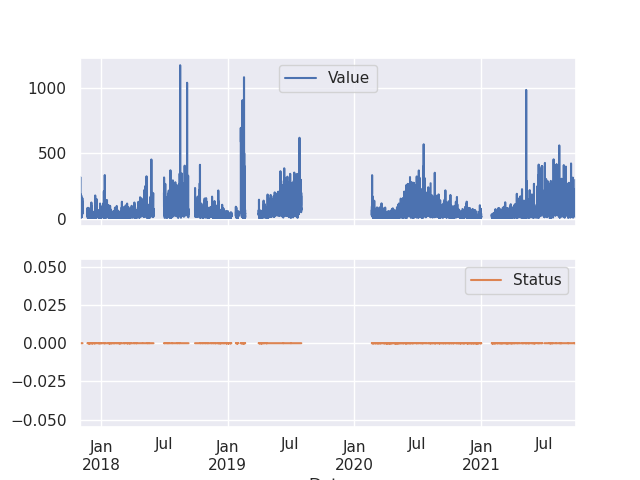

In [128]:
extractStation(dfRaw,'PM10','Diepsloot',Status=0)[['Value','Status']].plot(subplots=True)

## Data statistics

In [3]:
months={1:'January',
        2:'February',
        3:'March',
        4:'April',
        5:'May',
        6:'June',
        7:'July',
        8:'August',
        9:'September',
        10:'October',
        11:'November',
        12:'December'}

output=[["Agent", "Period", "Standard", "Exceeds", "Average", "Interval", "N", "N exceeds", "Std Dev", "Median", "25%", "75%", "99%"]]



Vars={"PM10 (ug/m3)",
      "PM2.5 (ug/m3)",
      "SO2 (ppb)",
      "NO2 (ppb)",
      "H2S (ppb)",
      "CO (ppm)",
      "O3 (ppb)"} 

DataAvailable={'1D':1152,
               'A':367920,
               '8H':384,
               '4H':192,
               '1H':48} 

def is_leap_year(year):
    return int(year % 4 == 0 and (year % 100 != 0 or year % 400 == 0))

def numdays(month,year):
    days={1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    if month == 2:
        return(days[month]+is_leap_year(year))
    else:
        return(days[month])



In [130]:
def confidence_interval(data, confidence=0.99):                                                                                                                                                                                                                                    
    a = 1.0*np.array(data)                                                                                                                                                                                                                                                         
    n = len(a)                                                                                                                                                                                                                                                                     
    m, se = np.mean(a), scipy.stats.sem(a)                                                                                                                                                                                                                                         
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)                                                                                                                                                                                                                               
    return( m-h, m+h)  

In [136]:
Stations

,Station_SAAQIS_Name,Station_Name,Type,Owner,Location,Province,District,Latitude,Longitude,Height
0,Algoa park Clinic,Algoa Park Clinic,Residential - Medium/Upper income,Nelson Mandela Metropolitan,Algoa Park residential area,Eastern Cape,Nelson Mandela Bay Metro,-33.901361,25.564167,0
1,Mobile,Mobile,Residential - Low Income,Buffalo City Metropolitan,"Gompo Clinic, East London",Eastern Cape,Buffalo City Metro,-33.014944,27.849248,0
2,Motherwell,Motherwell,Residential - Low Income,Coega Development Corporation,Ikamvelihle township,Eastern Cape,Nelson Mandela Bay Metro,-33.795488,25.616957,0
3,Motherwell Day Hospital,Motherwell Day Hospital,Residential - Medium/Upper Income,Nelson Mandela Metropolitan,Motherwell Day Hospital,Eastern Cape,Nelson Mandela Bay Metro,-33.811066,25.597658,54
4,Saltworks - NAQI,Saltworks - NAQI,Traffic - Street Canyon,Coega Development Corporation,Coega Special Economic Zone (SEZ),Eastern Cape,Nelson Mandela Bay Metro,-33.763778,25.683428,46
...,...,...,...,...,...,...,...,...,...,...
183,City Hall,City Hall,Traffic - Roadside,City of Cape Town,"Cape Town city hall (CBD), Darling Street",WesternCape,Cape Town,-33.9253,18.4238393,0
184,Drill Hall,,,,,,Cape Town,-33.9259,18.4246681,
185,Ferndale,,,,,,eThekwini,-29.7779,30.22211,
186,Jacobs Air Monitoring,,,,,,eThekwini,-29.9317,30.976995,


In [2]:
Threshold=65
Data=[]
for s in CStations:
    for v in ['PM10','PM2.5']:
        df=extractStation(dfRaw,v,s,Status=0)
        # Daily averages
        tValue=df['Value'].dropna().resample('1D').mean()
        tCount=df['Value'].dropna().resample('1D').count()
        tDaily=pd.concat([tValue,tCount],axis=1)
        tDaily.columns=['Mean','N']
        tDaily.loc[tDaily['N']/24*100<Threshold,'Mean']=np.nan

        # Monthly averages
        tValue=tDaily['Mean'].dropna().resample('1M').mean()
        tCount=tDaily['Mean'].dropna().resample('1M').count()
        tMonthly=pd.concat([tValue,tCount],axis=1)
        tMonthly.columns=['Mean','N']
        tMonthly.loc[tMonthly['N']/tMonthly.index.days_in_month*100<Threshold,'Mean']=np.nan

        # Annual average
        tValue=tMonthly['Mean'].dropna().resample('1Y').mean()
        tCount=tMonthly['Mean'].dropna().resample('1Y').count()
        tAnnual=pd.concat([tValue,tCount],axis=1)
        tAnnual.columns=['Mean','N']
        tAnnual.loc[tAnnual['N']/12*100<Threshold,'Mean']=np.nan

        #
        if len(tAnnual['Mean'].dropna()) > 0:
            Data.append([s,v,tAnnual['Mean'].mean(),tAnnual['Mean'].count()])
            print("{},{},{:.1f},{}".format(s,v,tAnnual['Mean'].mean(),tAnnual['Mean'].count()))
        else:
            tMonthly['Month']=tMonthly.index.month
            tMonthly=tMonthly.groupby('Month').mean()[['Mean']]
            if tMonthly['Mean'].count()/12*100>Threshold:
                print("{},{},{:.1f},{} months".format(s,v,tMonthly['Mean'].mean(),tMonthly['Mean'].count()))
                Data.append([s,v,tMonthly['Mean'].mean(),tMonthly['Mean'].count()])
    

dfAnn=pd.pivot_table(pd.DataFrame(data=Data, columns=['Site','Variable','Average','N']),index='Site',columns='Variable',values=['Average','N'])
dfAnn

NameError: name 'CStations' is not defined

In [143]:
dfAnn=pd.pivot_table(pd.DataFrame(data=Data, columns=['Site','Variable','Average','N']),index='Site',columns='Variable',values=['Average','N'])
dfAnn

Average                N      
Variable                PM10      PM2.5  PM10 PM2.5
Site                                               
Alexandra          69.000843  35.930254   1.0   1.0
Bedfordview        48.984103  27.646535   3.0   3.0
Bodibeng           69.062161  30.225458  10.0   1.0
Booysens           72.324412        NaN  10.0   NaN
Buccleugh          41.742300        NaN   8.0   NaN
Diepkloof          37.803183  24.196835   5.0   3.0
Diepsloot          43.107692        NaN   2.0   NaN
Etwatwa            98.780250  52.327086   2.0   2.0
Hammanskraal       63.237761  26.819970   1.0   1.0
Ivory_park         49.146207        NaN  11.0   NaN
Jabavu             66.961013  40.984532   4.0   3.0
Kliprivier         56.798591  38.340758   3.0   2.0
Mamelodi          234.515924        NaN   1.0   NaN
NWU_Vaal           44.171942  26.236204   2.0   2.0
Olievenhoutbosch   97.224015  38.684320  10.0   1.0
Olifantsfontein    70.700723  33.903615   2.0   2.0
Orange_Farm        42.971296        NaN  11.0   NaN
PTA_West           29.572599        NaN   1.0   NaN
Randwater                NaN  21.012719   NaN  11.0
Rosslyn            33.412865  25.575655   2.0   1.0
Sebokeng           39.084772  31.259781   1.0   1.0
Sharpeville        57.828645  36.579435   1.0   1.0
Springs            39.628488  32.416056   2.0   1.0
Thokoza-NAQI       93.881687        NaN   2.0   NaN
Three Rivers       61.341365  27.507806   3.0   3.0
Tswane_Market      47.084085  35.883437   1.0   1.0
Vanderbijlpark     69.430570  30.752688   4.0   2.0

In [144]:
dfAnn.sort_values(('Average','PM10'), ascending=False)

Average                N      
Variable                PM10      PM2.5  PM10 PM2.5
Site                                               
Mamelodi          234.515924        NaN   1.0   NaN
Etwatwa            98.780250  52.327086   2.0   2.0
Olievenhoutbosch   97.224015  38.684320  10.0   1.0
Thokoza-NAQI       93.881687        NaN   2.0   NaN
Booysens           72.324412        NaN  10.0   NaN
Olifantsfontein    70.700723  33.903615   2.0   2.0
Vanderbijlpark     69.430570  30.752688   4.0   2.0
Bodibeng           69.062161  30.225458  10.0   1.0
Alexandra          69.000843  35.930254   1.0   1.0
Jabavu             66.961013  40.984532   4.0   3.0
Hammanskraal       63.237761  26.819970   1.0   1.0
Three Rivers       61.341365  27.507806   3.0   3.0
Sharpeville        57.828645  36.579435   1.0   1.0
Kliprivier         56.798591  38.340758   3.0   2.0
Ivory_park         49.146207        NaN  11.0   NaN
Bedfordview        48.984103  27.646535   3.0   3.0
Tswane_Market      47.084085  35.883437   1.0   1.0
NWU_Vaal           44.171942  26.236204   2.0   2.0
Diepsloot          43.107692        NaN   2.0   NaN
Orange_Farm        42.971296        NaN  11.0   NaN
Buccleugh          41.742300        NaN   8.0   NaN
Springs            39.628488  32.416056   2.0   1.0
Sebokeng           39.084772  31.259781   1.0   1.0
Diepkloof          37.803183  24.196835   5.0   3.0
Rosslyn            33.412865  25.575655   2.0   1.0
PTA_West           29.572599        NaN   1.0   NaN
Randwater                NaN  21.012719   NaN  11.0

In [145]:
%matplotlib inline

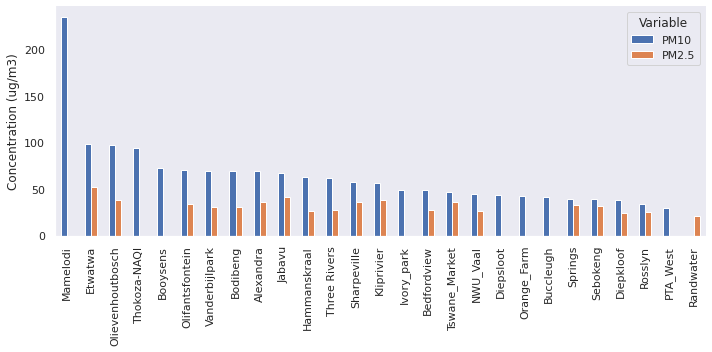

In [146]:
dfAnn.sort_values(('Average','PM10'), ascending=False, inplace=True)
ax=dfAnn['Average'].plot(kind='bar',figsize=(10,5))
ax.spines["top"].set_visible(False)
#ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Concentration (ug/m3)")
ax.set_xlabel("")

#ax.set_xlim(0,250)
ax.grid(False)
plt.tight_layout()

In [1]:
tMonthly['Month']=tMonthly.index.month

NameError: name 'tMonthly' is not defined

In [157]:
tMonthly.groupby('Month').mean()[['Mean']]

,Mean
Month,


In [158]:
MonthlyData={'2019-9': nan, '2019-10': nan, '2019-11': nan, '2019-12': nan, '2020-1': nan, '2020-2': nan, '2020-3': nan, '2020-4': 20.398687189883233, '2020-5': 44.07887038715143, '2020-6': 61.4292132147443, '2020-7': 66.48916639928699, '2020-8': 60.349549253782214, '2020-9': 46.84546059414222, '2020-10': 36.63706487240413, '2020-11': nan, '2020-12': nan, '2021-1': nan, '2021-2': nan, '2021-3': 29.033994927678318, '2021-4': 40.97100095359019, '2021-5': 49.59832049077734, '2021-6': 32.89086654353238, '2021-7': 39.439830522971654, '2021-8': 39.264025589082685, '2021-9': 34.77969635674587, '2021-10': nan}

In [159]:
DailyData

NameError: name 'DailyData' is not defined

In [160]:
MonthlyData

{'2019-9': nan,
 '2019-10': nan,
 '2019-11': nan,
 '2019-12': nan,
 '2020-1': nan,
 '2020-2': nan,
 '2020-3': nan,
 '2020-4': 20.398687189883233,
 '2020-5': 44.07887038715143,
 '2020-6': 61.4292132147443,
 '2020-7': 66.48916639928699,
 '2020-8': 60.349549253782214,
 '2020-9': 46.84546059414222,
 '2020-10': 36.63706487240413,
 '2020-11': nan,
 '2020-12': nan,
 '2021-1': nan,
 '2021-2': nan,
 '2021-3': 29.033994927678318,
 '2021-4': 40.97100095359019,
 '2021-5': 49.59832049077734,
 '2021-6': 32.89086654353238,
 '2021-7': 39.439830522971654,
 '2021-8': 39.264025589082685,
 '2021-9': 34.77969635674587,
 '2021-10': nan}

In [161]:
MonthlyData.values()

dict_values([nan, nan, nan, nan, nan, nan, nan, 20.398687189883233, 44.07887038715143, 61.4292132147443, 66.48916639928699, 60.349549253782214, 46.84546059414222, 36.63706487240413, nan, nan, nan, nan, 29.033994927678318, 40.97100095359019, 49.59832049077734, 32.89086654353238, 39.439830522971654, 39.264025589082685, 34.77969635674587, nan])

In [162]:
daily=pd.DataFrame(DailyData).transpose()
daily.columns=['Mean','Perc']
daily.loc[daily['Perc']<Threshold,'Mean']=np.nan

NameError: name 'DailyData' is not defined

In [163]:
daily['Mean'].count()

NameError: name 'daily' is not defined

In [164]:
daily

NameError: name 'daily' is not defined

In [165]:
DailyData

NameError: name 'DailyData' is not defined

In [166]:
dftmp['2021-04'].describe()

KeyError: '2021-04'

In [167]:
numdays(9,2018)

30

In [168]:
df.index.month.unique()

Int64Index([], dtype='int64', name='Date')

In [169]:
def SummaryTable(df,month):
    days={1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    ndur={'1D':1,'8H':3,'1H':24}
    ndays=days[month]
    pols=[["PM10",'1D',75,4],
          ["PM2.5",'1D',40,4],
          ["SO2","1H",134,88],
          ["SO2","1D",48,4],
          ["NO2","1H",106,88],
          ["CO","1H",26,88],
          ["CO","8H",8.7,11],
          ["O3","8H",61,11]]

    output=[["Agent", "Period", "Standard", "Exceeds", "Average", "Interval", "N", "N exceeds", "Std Dev", "Median", "25%", "75%", "99%","DataAvailable (%)"]]
    for p in pols:
        pname=p[0]
        pdur=p[1]
        paqs=p[2]
        pexc=p[3]
        #print("Doing",pname,pdur,paqs,pexc)
        if pdur == "A":
            t1=df[[pname]].dropna().resample('1M').mean()
            t2=df[[pname]].dropna().resample('1M').count()
            t2.columns=['N']
            if t2.sum()[0] < 34560:
                N=0
                Nexc=np.nan
            else:
                N=1
                if t1.mean()[0] > paqs:
                    Nexc=1
                else:
                    Nexc=0
        else:
            if pdur == '8H':
                t1=df[[pname]].resample('1H').mean().rolling(window=8,min_periods=4).mean()
                t2=df[[pname]].dropna().resample('1H').mean().rolling(window=8,min_periods=4).count()
            else:
                t1=df[[pname]].dropna().resample(pdur).mean()
                t2=df[[pname]].dropna().resample(pdur).count()
                # t1.ix[df[pname]<10,pname]=np.nan
                t2.columns=['N']
                t=pd.concat([t1,t2],axis=1)
                t.loc[t['N']<DataAvailable[pdur],pname]=np.nan
                N=len(t[pname].dropna())
                Nexc=len(t[t[pname]>paqs])
        if N>4:
            #print(t[pname].dropna().describe())
            if N<30:
                CIs=confidence_interval(t[pname].dropna().values)
                #bootstrap.ci(data=t[pname].dropna(),statfunction=sp.mean,alpha=0.05)
            elif N>5:
                CIs=confidence_interval(t[pname].dropna().values)
            else:
                CIs=["",""]
            Pave=t[pname].mean()
            Pstd=t[pname].std()
            P50=t[pname].quantile(0.5)
            P25=t[pname].quantile(0.25)
            P75=t[pname].quantile(0.75)
            P99=t[pname].quantile(0.99)
        else:
            CIs=[np.nan,np.nan]
            Pave=t[pname].mean()
            Pstd=np.nan
            P50=np.nan
            P25=np.nan
            P75=np.nan
            P99=np.nan
        #print(t[pname].mean(),CIs,N)
        DA=N/(ndays*ndur[pdur])*100
        output.append([pname,pdur,paqs,pexc,"%.0f" % (Pave),"%.0f-%.0f" % (CIs[0],CIs[1]),N,Nexc,"%.0f" % (Pstd),"%.0f" % (P50),"%.0f" % (P25),"%.0f" % (P75),"%.0f" % (P99),"%.0f" % (DA)])
        a=np.array(output)
        df2=pd.DataFrame(data=a[1:,1:],index=a[1:,0],columns=a[0,1:])
        df2=df2.replace("nan-nan", "")
        df2=df2.replace("nan", "")
        #print(t)
    return(df2)


In [170]:
def DataAvailableTable(df):
    #output=[["Parameter", "Data Available (mins)", "DataAvailable (%)"]]
    output={}
    TotalHours=len(df['Value'])
    HoursData=len(df['Value'].dropna())
    output['Value']=["{:.0f}".format(HoursData),"{:.0f}".format(HoursData/TotalHours*100)]
    return(output)  

In [171]:
Stations

,Station_SAAQIS_Name,Station_Name,Type,Owner,Location,Province,District,Latitude,Longitude,Height
0,Algoa park Clinic,Algoa Park Clinic,Residential - Medium/Upper income,Nelson Mandela Metropolitan,Algoa Park residential area,Eastern Cape,Nelson Mandela Bay Metro,-33.901361,25.564167,0
1,Mobile,Mobile,Residential - Low Income,Buffalo City Metropolitan,"Gompo Clinic, East London",Eastern Cape,Buffalo City Metro,-33.014944,27.849248,0
2,Motherwell,Motherwell,Residential - Low Income,Coega Development Corporation,Ikamvelihle township,Eastern Cape,Nelson Mandela Bay Metro,-33.795488,25.616957,0
3,Motherwell Day Hospital,Motherwell Day Hospital,Residential - Medium/Upper Income,Nelson Mandela Metropolitan,Motherwell Day Hospital,Eastern Cape,Nelson Mandela Bay Metro,-33.811066,25.597658,54
4,Saltworks - NAQI,Saltworks - NAQI,Traffic - Street Canyon,Coega Development Corporation,Coega Special Economic Zone (SEZ),Eastern Cape,Nelson Mandela Bay Metro,-33.763778,25.683428,46
...,...,...,...,...,...,...,...,...,...,...
183,City Hall,City Hall,Traffic - Roadside,City of Cape Town,"Cape Town city hall (CBD), Darling Street",WesternCape,Cape Town,-33.9253,18.4238393,0
184,Drill Hall,,,,,,Cape Town,-33.9259,18.4246681,
185,Ferndale,,,,,,eThekwini,-29.7779,30.22211,
186,Jacobs Air Monitoring,,,,,,eThekwini,-29.9317,30.976995,


In [172]:
Sites=Stations

In [173]:
df=extractStation(dfRaw,'PM10','Diepsloot',Status=0)

In [174]:
DataAvailableTable(df)

{'Value': ['23933', '70']}

In [175]:
pd.DataFrame(DataAvailableTable(df['2021']),index=['Minutes','Percentage']).transpose()

/tmp/ipykernel_48063/1259554185.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  pd.DataFrame(DataAvailableTable(df['2021']),index=['Minutes','Percentage']).transpose()


,Minutes,Percentage
Value,5133,78


In [176]:
dfRaw

,Date,Site,Value,Variable,Unit,Status,Authority
750113358092996791,2017-10-01 01:00:00,Diepkloof,0.124,CO,ppm,0,GJA
134530363436357924,2017-10-01 01:00:00,Kliprivier,0.906,CO,ppm,0,GJA
7941784539085327057,2017-10-01 01:00:00,Sebokeng,0.486,CO,ppm,0,GJA
7036644425052196675,2017-10-01 01:00:00,Sharpeville,0.579,CO,ppm,0,GJA
-5965926600459050408,2017-10-01 01:00:00,Three Rivers,0.627,CO,ppm,0,GJA
...,...,...,...,...,...,...,...
2856696761785629815,2020-10-01 00:00:00,Buccleugh,20.925,NOx,ppm,0,GJA
-4506388115447205489,2020-10-01 00:00:00,Booysens,40.400,NOx,ppm,0,GJA
2958974752638786927,2020-10-01 00:00:00,Tswane_Market,22.858,NOx,ppm,0,GJA
-6141358301737777023,2020-10-01 00:00:00,Bodibeng,7.381,NOx,ppm,0,GJA


In [177]:
variables

NameError: name 'variables' is not defined

In [178]:
dfRaw[dfRaw['Site']=='Sebokeng']['Authority'].values[0]

'GJA'

In [179]:
for s in dfRaw.Site.unique():
    print("{},{}".format(s,dfRaw[dfRaw['Site']==s]['Authority'].values[0]))

Diepkloof,GJA
Kliprivier,GJA
Sebokeng,GJA
Sharpeville,GJA
Three Rivers,GJA
Etwatwa,GJA
Olifantsfontein,GJA
Springs,GJA
Tsakane,GJA
Wattville,GJA
Booysens,GJA
Ekandustria,GJA
Mamelodi,GJA
Rosslyn,GJA
Bodibeng,GJA
Mogale_City,GJA
Olievenhoutbosch,GJA
PTA_West,GJA
Hammanskraal,GJA
Thokoza-NAQI,GJA
Tswane_Market,GJA
Randwater,GJA
Bedfordview,GJA
Buccleugh,GJA
Tembisa,GJA
Randfontein,GJA
Leondale_City,GJA
Jabavu,GJA
Meyerton,GJA
Vanderbijlpark,GJA
Diepsloot,GJA
Springs-new,GJA
Orange_Farm,GJA
Alexandra,GJA
NWU_Vaal,GJA
Ivory_park,GJA


In [180]:
dfRaw[['PM10']]['2021-09'].plot()

KeyError: "None of [Index(['PM10'], dtype='object')] are in the [columns]"

In [181]:
df=extractStation(dfRaw,'PM10','Tembisa',Status=0)

<AxesSubplot:xlabel='Date'>

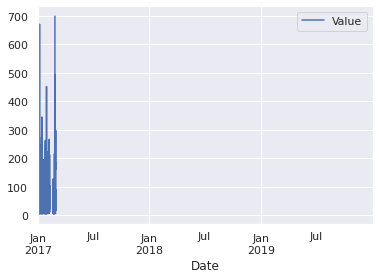

In [182]:
df[['Value']]['2017':'2019'].plot()

# Visualization

In [183]:
clearplots()

<Figure size 432x288 with 0 Axes>

In [184]:
dfRaw

,Date,Site,Value,Variable,Unit,Status,Authority
750113358092996791,2017-10-01 01:00:00,Diepkloof,0.124,CO,ppm,0,GJA
134530363436357924,2017-10-01 01:00:00,Kliprivier,0.906,CO,ppm,0,GJA
7941784539085327057,2017-10-01 01:00:00,Sebokeng,0.486,CO,ppm,0,GJA
7036644425052196675,2017-10-01 01:00:00,Sharpeville,0.579,CO,ppm,0,GJA
-5965926600459050408,2017-10-01 01:00:00,Three Rivers,0.627,CO,ppm,0,GJA
...,...,...,...,...,...,...,...
2856696761785629815,2020-10-01 00:00:00,Buccleugh,20.925,NOx,ppm,0,GJA
-4506388115447205489,2020-10-01 00:00:00,Booysens,40.400,NOx,ppm,0,GJA
2958974752638786927,2020-10-01 00:00:00,Tswane_Market,22.858,NOx,ppm,0,GJA
-6141358301737777023,2020-10-01 00:00:00,Bodibeng,7.381,NOx,ppm,0,GJA


In [185]:
def extractStationVars(df,Site="",Vars=[],Status=0):
    df=df[(df['Status']<=Status)&(df['Site']==Site)]
    df=pd.pivot_table(df,index=['Date'],columns=['Variable'],values=['Value'])
    df.index=pd.to_datetime(df.index)
    df.columns=df.columns.droplevel(0)
    if len(Vars) > 0:
        Vars=[v for v in Vars if v in df.columns]
        df=df[Vars]
    df=df.resample('1H').first()
    return(df)

In [186]:
dftmp=extractStationVars(dfRaw,Site='Jabavu')
#dftmp.columns=dftmp.columns.droplevel(0)

In [187]:
dftmp.head()

Variable,O3,PM10,PM2.5,RH,SO2,SolarRadiation,Temperature,WindDir,WindSpeed
Date,,,,,,,,,
2016-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1.01,8.07,0.14,0.4
2016-06-01 01:00:00,NaN,NaN,NaN,NaN,NaN,1.01,7.64,0.14,0.4
2016-06-01 02:00:00,NaN,NaN,NaN,NaN,NaN,1.01,7.25,0.12,0.4
2016-06-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1.00,6.62,0.13,0.4
2016-06-01 04:00:00,NaN,NaN,NaN,NaN,NaN,1.00,5.58,0.13,0.4


<AxesSubplot:>

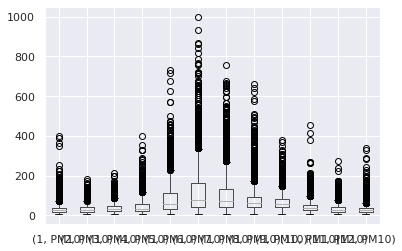

In [188]:
dftmp[['PM10']].groupby(dftmp.index.month).boxplot(subplots=False)

<AxesSubplot:xlabel='Date', ylabel='Concentration (ug/m3)'>

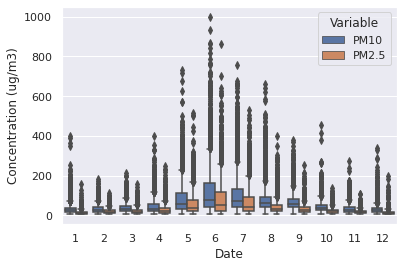

In [189]:
%matplotlib inline
df2=dftmp[['PM10','PM2.5']].stack().reset_index()
df2.columns=['Date','Variable','Concentration (ug/m3)']
df2.index = df2['Date']
sns.boxplot(x=df2.index.month,y='Concentration (ug/m3)',hue='Variable',data=df2)

In [142]:
p10=lambda x: np.percentile(x[~np.isnan(x)],10)
p10.__name__='p10'
p25=lambda x: np.percentile(x[~np.isnan(x)],25)
p25.__name__='p25'
p75=lambda x: np.percentile(x[~np.isnan(x)],75)
p75.__name__='p75'
p90=lambda x: np.percentile(x[~np.isnan(x)],90)
p90.__name__='p90'

In [143]:
df3=pd.pivot_table(dftmp,index=dftmp.index.month,columns=dftmp.index.hour, values=['PM2.5'],aggfunc=[p10,p25,p75,p90]).stack()
df3

p10       p25       p75      p90
Variable     PM2.5     PM2.5     PM2.5    PM2.5
Date Date                                      
1    0      7.7835   9.74525  21.98975  41.0575
     1      7.0261   8.76700  20.50950  40.9622
     2      5.7752   8.86125  20.87100  33.1648
     3      7.1371   9.22850  19.79900  29.9875
     4      6.8132   8.55000  19.85000  26.2066
...            ...       ...       ...      ...
12   19     7.0459   8.62700  20.11375  27.9498
     20     8.8290  12.12150  22.82150  30.4248
     21    10.5421  12.56150  28.18750  39.0382
     22     9.2940  12.74850  26.91650  42.9058
     23     8.1660  10.85400  25.30700  39.9310

[288 rows x 4 columns]

In [144]:
df3.loc[1,0]['p10'].values[0]

7.7835

In [145]:
getAQClimate(dftmp,var="PM2.5",start="2021-03-15",end="2021-03-16")

Variable,PM2.5,PM2.5p10,PM2.5p90,PM2.5p25,PM2.5p75
Date,,,,,
2021-03-15 00:00:00,16.981,10.3200,68.6436,16.76900,50.31700
2021-03-15 01:00:00,22.337,9.2760,57.3378,14.64700,43.18100
2021-03-15 02:00:00,11.097,8.4742,46.7360,12.44800,39.20900
2021-03-15 03:00:00,10.590,8.2686,41.0422,11.08625,34.06175
2021-03-15 04:00:00,9.297,8.9639,43.2213,12.43725,28.51975
2021-03-15 05:00:00,8.211,7.7180,38.4248,12.86100,26.76600
2021-03-15 06:00:00,7.423,9.4052,37.0050,13.36500,26.31500
2021-03-15 07:00:00,10.875,10.4903,35.7724,13.44125,27.95450
2021-03-15 08:00:00,10.192,8.3348,42.7833,12.97275,30.27325


## Period plots

In [146]:
def cleanplot(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

def getAQClimate(df,var="",start="",end=""):

    p10=lambda x: np.percentile(x[~np.isnan(x)],10)
    p10.__name__='p10'
    p25=lambda x: np.percentile(x[~np.isnan(x)],25)
    p25.__name__='p25'
    p75=lambda x: np.percentile(x[~np.isnan(x)],75)
    p75.__name__='p75'
    p90=lambda x: np.percentile(x[~np.isnan(x)],90)
    p90.__name__='p90'
    df2=pd.pivot_table(dftmp,index=dftmp.index.month,columns=dftmp.index.hour, values=[var],aggfunc=[p10,p25,p75,p90]).stack()

    df1=df[start:end][[var]]
    df1[var+'p10']=np.nan
    df1[var+'p90']=np.nan
    df1[var+'p25']=np.nan
    df1[var+'p75']=np.nan
    for idx,row in df1.iterrows():
        df1.loc[idx,var+'p10']=df2.loc[idx.month,idx.hour]['p10'].values[0]
        df1.loc[idx,var+'p90']=df2.loc[idx.month,idx.hour]['p90'].values[0]
        df1.loc[idx,var+'p25']=df2.loc[idx.month,idx.hour]['p25'].values[0]
        df1.loc[idx,var+'p75']=df2.loc[idx.month,idx.hour]['p75'].values[0]
    return(df1)
    
def plotTimeSeriesPeriod(df,title="", var="", start="",end="",climate=False):
    
    
    # Size of 1x graph y-axis
    Y=2
    
    mpl.style.use('default')
    
    # Set period
    if len(start)>0 and len(end)>0:
        df2=df[start:end]
    elif len(start)>0 and len(end)==0:
        df2=df[start:]
    elif len(start)==0 and len(end)>0:
        df2=df[:end]
    else:
        df2=df
       
    #df=df.resample('1D').mean()
    # Count the number of plots
    n=0
    plotpm10=False
    plotpm25=False
    plotso2=False
    plotno=False
    plotno2=False
    ploto3=False
    plotwinds=True
    
    if 'PM10' in df.columns and len(df2['PM10'].dropna()) > 0:
        n=n+1
        plotpm10=True
    if 'PM2.5' in df.columns and len(df2['PM2.5'].dropna()) > 0:
        n=n+1
        plotpm25=True
    if 'SO2' in df.columns and len(df2['SO2'].dropna()) > 0:
        n=n+1
        plotso2=True
        
    ysize=n*Y
    f,ax = plt.subplots(n,sharex=True, figsize=[8,ysize]) # fig.add_subplot(1,1,1)
    i=0
    
    if plotpm10:
        df3=getAQClimate(df,var="PM10",start=start,end=end)
        ax[i].fill_between(df3.index, df3['PM10p10'], df3['PM10p90'], alpha=.25, facecolor='tab:blue', label='10-90%')                                                                                                                                                                                      
        ax[i].fill_between(df3.index, df3['PM10p25'], df3['PM10p75'], alpha=.5, facecolor='tab:blue', label='25-75%') 
        ax[i].plot(df2.index,df2['PM10'], color='tab:orange', label='PM10 (ug/m3)')
        cleanplot(ax[i])
        ax[i].set_ylabel("ug/m3")     
        ax[i].legend()
        i=i+1
        
    if plotpm25:
        df3=getAQClimate(df,var="PM2.5",start=start,end=end)
        ax[i].fill_between(df3.index, df3['PM2.5p10'], df3['PM2.5p90'], alpha=.25, facecolor='tab:blue')                                                                                                                                                                                      
        ax[i].fill_between(df3.index, df3['PM2.5p25'], df3['PM2.5p75'], alpha=.5, facecolor='tab:blue') 
        ax[i].plot(df2.index,df2['PM2.5'], color='tab:orange', label='PM2.5 (ug/m3)')
        cleanplot(ax[i])
        ax[i].set_ylabel("ug/m3")     
        ax[i].legend()
        i=i+1
                
    if plotso2:
        df3=getAQClimate(df,var="SO2",start=start,end=end)
        ax[i].fill_between(df3.index, df3['SO2p10'], df3['SO2p90'], alpha=.25, facecolor='tab:blue')                                                                                                                                                                                      
        ax[i].fill_between(df3.index, df3['SO2p25'], df3['SO2p75'], alpha=.5, facecolor='tab:blue') 
        ax[i].plot(df2.index,df2['SO2'], color='tab:orange', label='SO2 (ppb)')
        cleanplot(ax[i])
        ax[i].legend()
        ax[i].set_ylabel("ppb")     
        i=i+1
    
    i=i-1
    # Hide the spines of the figure
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    plt.xticks(fontsize=9)
    # Ensure that the ax1is ticks only show up on the bottom and left of the plot.
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.
    ax[i].get_xaxis().tick_bottom()
    ax[i].get_yaxis().tick_left()
    
    if len(title) > 0:
        f.suptitle(title)
    plt.tight_layout()
    #plt.savefig('Figure.png', bbox_inches='tight', dpi=300)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
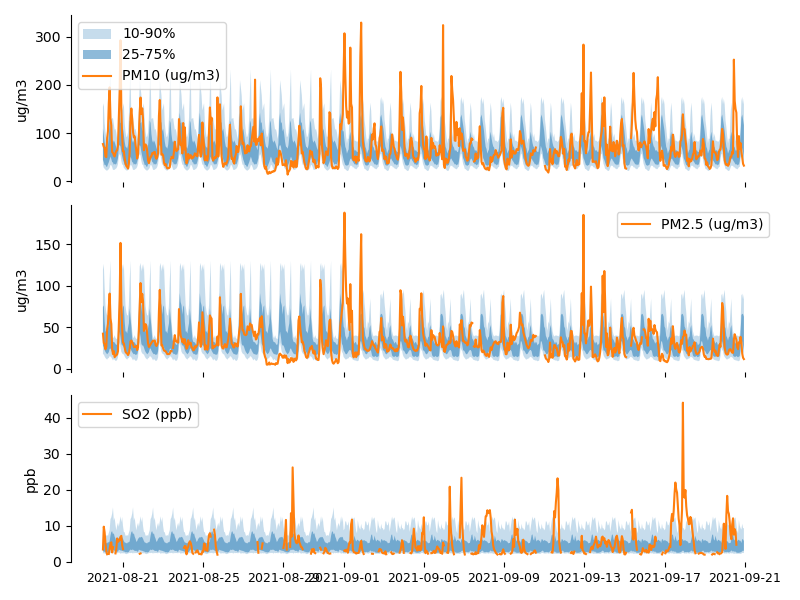

In [166]:
plotTimeSeriesPeriod(dftmp,var="PM10",start="2021-08-20",end="2021-09-20",title="")

In [153]:
def plotTimeSeries(df,title=""):
    # Size of 1x graph y-axis
    Y=2
    
    mpl.style.use('default')
    
        
    #df=df.resample('1D').mean()
    # Count the number of plots
    n=0
    plotpm10=False
    plotpm25=False
    plotso2=False
    plotno=False
    plotno2=False
    ploto3=False
    plotwinds=True
    
    if 'PM10' in df.columns and len(df['PM10'].dropna()) > 0:
        n=n+1
        plotpm10=True
    if 'PM2.5' in df.columns and len(df['PM2.5'].dropna()) > 0:
        if not plotpm10:
            n=n+1
        plotpm25=True
    if 'SO2' in df.columns and len(df['SO2'].dropna()) > 0:
        n=n+1
        plotso2=True
    if 'NO' in df.columns and len(df['NO'].dropna()) > 0:
        n=n+1
        plotno=True
    if 'NO2' in df.columns and len(df['NO2'].dropna()) > 0:
        if not plotno:
            n=n+1      
        plotno2=True
    if 'O3' in df.columns and len(df['O3'].dropna()) > 0:
        if not plotno and not plotno2:
            n=n+1
        ploto3=True
        
    if 'WindSpeed' in df.columns and len(df['WindSpeed'].dropna()) > 0 and 'WindDir' in df.columns and len(df['WindDir'].dropna()) > 0:
        n=n+1
        plotwinds=True
        
    print(n)
    ysize=n*Y
    f,ax = plt.subplots(n,sharex=True, figsize=[8,ysize]) # fig.add_subplot(1,1,1)
    i=0
    
    if plotpm10:
        ax[i].plot(df.index,df['PM10'], color='tab:orange', label='PM10 (ug/m3)')
    if plotpm25:
        ax[i].plot(df.index,df['PM2.5'], color='tab:blue', label='PM10 (ug/m3)')
    if plotpm10 or plotpm25:
        cleanplot(ax[i])
        ax[i].legend(ncol=2)
        ax[i].set_ylabel("ug/m3")     
        i=i+1
        
    if plotso2:
        ax[i].plot(df.index,df['SO2'], color='tab:blue', label='SO2 (ppb)')
        cleanplot(ax[i])
        ax[i].legend()
        ax[i].set_ylabel("ppb")     
        i=i+1

    if plotno:
        ax[i].plot(df.index,df['NO'], color='tab:blue', label='NO (ppb)')
    if plotno2:
        ax[i].plot(df.index,df['NO2'], color='tab:green', label='NO2 (ppb)')
    if ploto3:
        ax[i].plot(df.index,df['O3'], color='tab:orange', label='O3 (ppb)')
    if plotno or plotno2 or ploto3:
        cleanplot(ax[i])
        ax[i].legend()
        ax[i].set_ylabel("ppb")  
        i=i+1
    
    if plotwinds:
        axw=ax[i].twinx()

        axw.plot(df.index,df['WindDir'], color='tab:orange', label='Wind Direction', alpha=.25)
        ax[i].plot(df.index,df['WindSpeed'], color='tab:blue', label='Wind Speed')

        ax[i].legend()
        axw.legend()
        ax[i].set_ylabel("m/s") 
        axw.set_ylabel("degrees")
        axw.spines["top"].set_visible(False)
        axw.spines["left"].set_visible(False)
        i=i+1
    
    i=i-1
    # Hide the spines of the figure
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)

    # Ensure that the ax1is ticks only show up on the bottom and left of the plot.
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.
    ax[i].get_xaxis().tick_bottom()
    ax[i].get_yaxis().tick_left()
    
    if len(title) > 0:
        f.suptitle(title)
    plt.tight_layout()
    #plt.savefig('Figure.png', bbox_inches='tight', dpi=300)

4


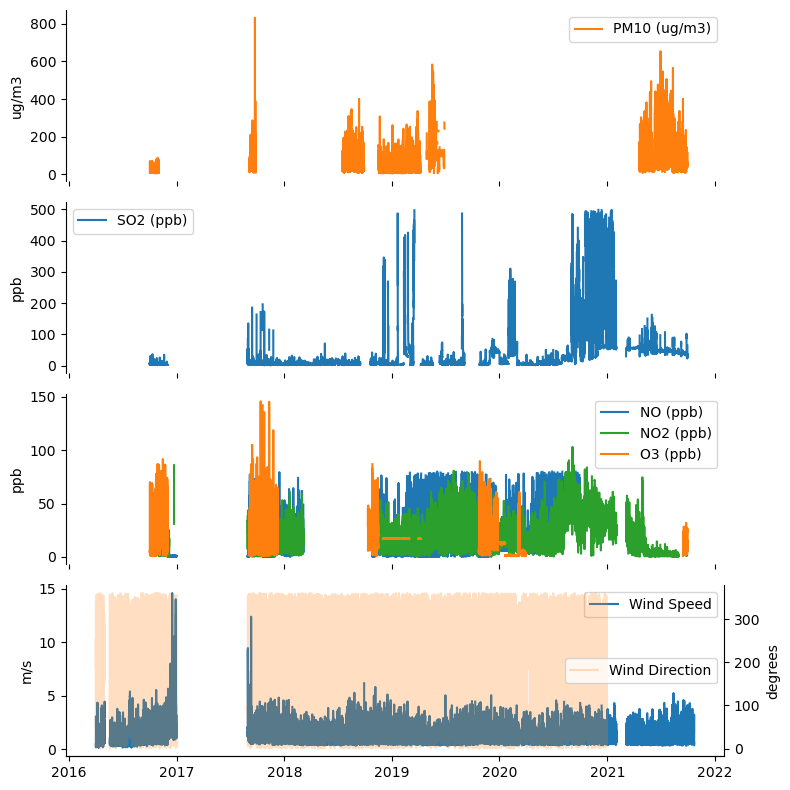

In [154]:
dfB=extractStationVars(dfRaw,Site='Booysens')
plotTimeSeries(dfB,title="")

In [155]:
np.

SyntaxError: invalid syntax (2469254449.py, line 1)

In [158]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
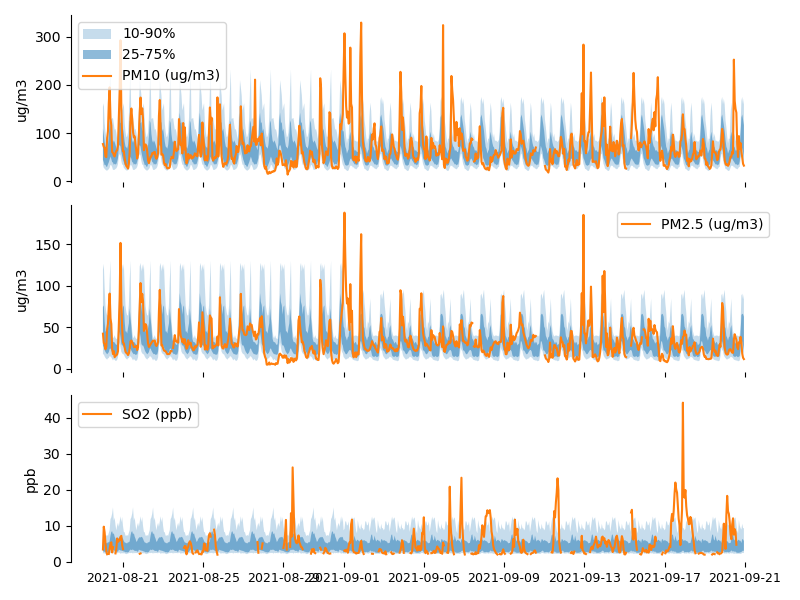

In [159]:
plotTimeSeriesPeriod(dftmp,var="PM2.5",start="2021-08-20",end="2021-09-20",title="")

4


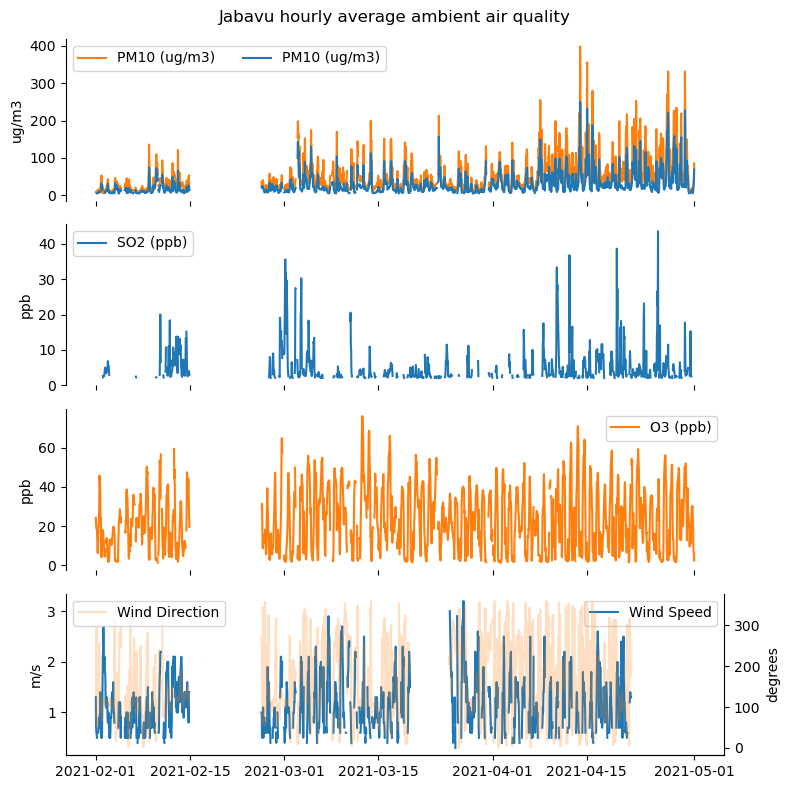

In [67]:
plotTimeSeries(dftmp['2021-02':'2021-04'], 'Jabavu hourly average ambient air quality')

In [68]:
Variables

array(['CO', 'NO2', 'NO', 'RH', 'WindDir', 'PM10', 'PM2.5',
       'SolarRadiation', 'O3', 'WindSpeed', 'Temperature', 'NOx', 'SO2'],
      dtype=object)

In [69]:
dftmp

Variable,O3,PM10,PM2.5,RH,SO2,SolarRadiation,Temperature,WindDir,WindSpeed
Date,,,,,,,,,
2016-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1.01,8.07,0.14,0.4
2016-06-01 01:00:00,NaN,NaN,NaN,NaN,NaN,1.01,7.64,0.14,0.4
2016-06-01 02:00:00,NaN,NaN,NaN,NaN,NaN,1.01,7.25,0.12,0.4
2016-06-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1.00,6.62,0.13,0.4
2016-06-01 04:00:00,NaN,NaN,NaN,NaN,NaN,1.00,5.58,0.13,0.4
...,...,...,...,...,...,...,...,...,...
2021-10-02 08:00:00,NaN,NaN,NaN,98.45,NaN,27.05,16.16,270.77,0.7
2021-10-02 09:00:00,NaN,NaN,NaN,98.28,NaN,87.08,16.83,274.01,1.6
2021-10-02 10:00:00,NaN,NaN,NaN,98.07,NaN,59.97,17.23,288.05,1.6


4


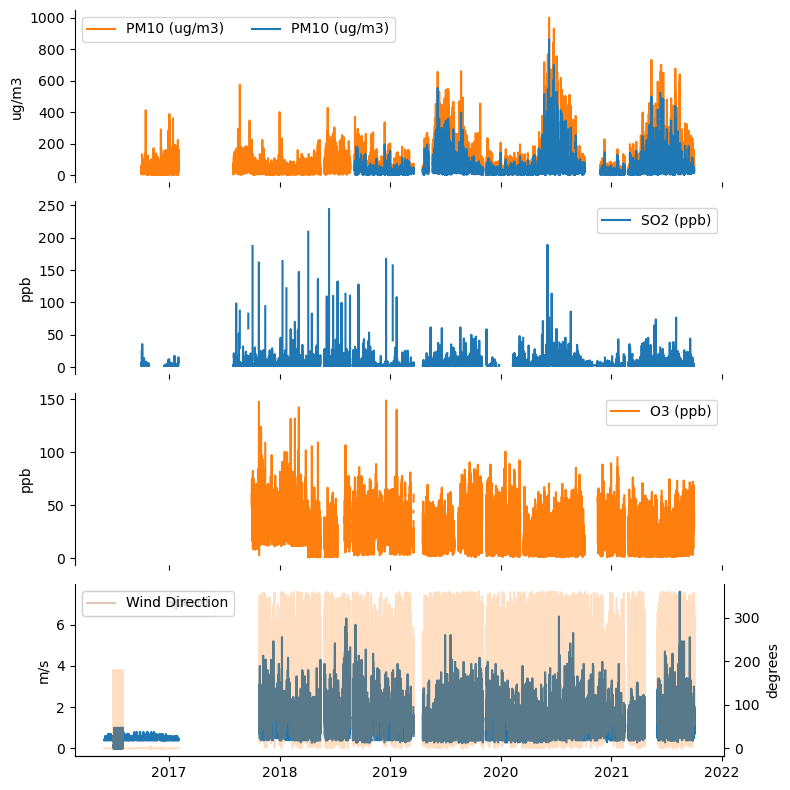

In [70]:
plotTimeSeries(dftmp['2021-09-'])

In [71]:
dftmp.columns=dftmp.columns.droplevel(0)

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

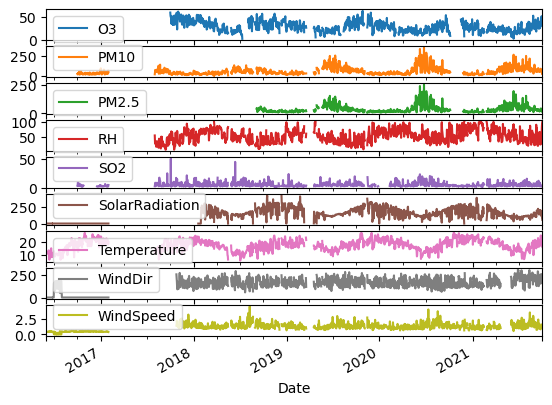

In [72]:
dftmp.resample('1D').mean().plot(subplots=True)

In [73]:
Stations

array(['Alexandra', 'Bedfordview', 'Bodibeng', 'Booysens', 'Buccleugh',
       'Diepkloof', 'Diepsloot', 'Ekandustria', 'Etwatwa', 'Hammanskraal',
       'Ivory_park', 'Jabavu', 'Kliprivier', 'Leondale_City', 'Mamelodi',
       'Meyerton', 'Mogale_City', 'NWU_Vaal', 'Olievenhoutbosch',
       'Olifantsfontein', 'Orange_Farm', 'PTA_West', 'Randfontein',
       'Randwater', 'Rosslyn', 'Sebokeng', 'Sharpeville', 'Springs',
       'Springs-new', 'Tembisa', 'Thokoza', 'Three Rivers', 'Tsakane',
       'Tswane_Market', 'Vanderbijlpark', 'Wattville'], dtype=object)

In [74]:
dftmp.resample('1M').count()

Variable,O3,PM10,PM2.5,RH,SO2,SolarRadiation,Temperature,WindDir,WindSpeed
Date,,,,,,,,,
2016-06-30,0,0,0,0,0,619,619,619,619
2016-07-31,0,0,0,0,0,741,741,741,741
2016-08-31,0,0,0,0,0,743,743,743,743
2016-09-30,0,0,0,0,0,720,720,720,720
2016-10-31,0,712,0,0,272,735,735,735,735
...,...,...,...,...,...,...,...,...,...
2021-06-30,596,610,607,620,365,624,622,611,442
2021-07-31,720,714,712,731,592,731,731,731,536
2021-08-31,739,743,741,744,379,744,744,744,639


In [75]:
pd.to_datetime(dftmp.index)

DatetimeIndex(['2016-06-01 00:00:00', '2016-06-01 01:00:00',
               '2016-06-01 02:00:00', '2016-06-01 03:00:00',
               '2016-06-01 04:00:00', '2016-06-01 05:00:00',
               '2016-06-01 06:00:00', '2016-06-01 07:00:00',
               '2016-06-01 08:00:00', '2016-06-01 09:00:00',
               ...
               '2021-10-02 03:00:00', '2021-10-02 04:00:00',
               '2021-10-02 05:00:00', '2021-10-02 06:00:00',
               '2021-10-02 07:00:00', '2021-10-02 08:00:00',
               '2021-10-02 09:00:00', '2021-10-02 10:00:00',
               '2021-10-02 11:00:00', '2021-10-02 12:00:00'],
              dtype='datetime64[ns]', name='Date', length=46789, freq='H')

In [76]:
help(pd.pivot)

Help on function pivot in module pandas.core.reshape.pivot:

pivot(data: 'DataFrame', index: Union[Hashable, NoneType, Sequence[Union[Hashable, NoneType]]] = None, columns: Union[Hashable, NoneType, Sequence[Union[Hashable, NoneType]]] = None, values: Union[Hashable, NoneType, Sequence[Union[Hashable, NoneType]]] = None) -> 'DataFrame'
    Return reshaped DataFrame organized by given index / column values.
    
    Reshape data (produce a "pivot" table) based on column values. Uses
    unique values from specified `index` / `columns` to form axes of the
    resulting DataFrame. This function does not support data
    aggregation, multiple values will result in a MultiIndex in the
    columns. See the :ref:`User Guide <reshaping>` for more on reshaping.
    
    Parameters
    ----------
    data : DataFrame
    index : str or object or a list of str, optional
        Column to use to make new frame's index. If None, uses
        existing index.
    
        .. versionchanged:: 1.1.0
  

In [77]:
dftmp

Variable,O3,PM10,PM2.5,RH,SO2,SolarRadiation,Temperature,WindDir,WindSpeed
Date,,,,,,,,,
2016-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1.01,8.07,0.14,0.4
2016-06-01 01:00:00,NaN,NaN,NaN,NaN,NaN,1.01,7.64,0.14,0.4
2016-06-01 02:00:00,NaN,NaN,NaN,NaN,NaN,1.01,7.25,0.12,0.4
2016-06-01 03:00:00,NaN,NaN,NaN,NaN,NaN,1.00,6.62,0.13,0.4
2016-06-01 04:00:00,NaN,NaN,NaN,NaN,NaN,1.00,5.58,0.13,0.4
...,...,...,...,...,...,...,...,...,...
2021-10-02 08:00:00,NaN,NaN,NaN,98.45,NaN,27.05,16.16,270.77,0.7
2021-10-02 09:00:00,NaN,NaN,NaN,98.28,NaN,87.08,16.83,274.01,1.6
2021-10-02 10:00:00,NaN,NaN,NaN,98.07,NaN,59.97,17.23,288.05,1.6


In [78]:
dfRaw['Date']=pd.to_datetime(dfRaw['Date'])

In [79]:
dfRaw['Date'].dt.month

 7860320140776357163    10
-1965297985333058308    10
-7485172957009719073    10
 3300082397400872614    10
-2307915222332187378    10
                        ..
-4098372955092856511    10
-4689913369471851562    10
 3712785171364353304    10
 6360184204476554464    10
 7066471988687593588    10
Name: Date, Length: 7986829, dtype: int64

In [80]:
dfRaw.head()

,Date,Site,Value,Variable,Unit,Status,Authority
7860320140776357163,2017-10-01 01:00:00,Diepkloof,0.124,CO,ppm,0,GJA
-1965297985333058308,2017-10-01 01:00:00,Kliprivier,0.906,CO,ppm,0,GJA
-7485172957009719073,2017-10-01 01:00:00,Sebokeng,0.486,CO,ppm,0,GJA
3300082397400872614,2017-10-01 01:00:00,Sharpeville,0.579,CO,ppm,0,GJA
-2307915222332187378,2017-10-01 01:00:00,Three Rivers,0.627,CO,ppm,0,GJA



## Quickly do daily averages compare

In [77]:
dfRaw.head()

,Date,Site,Value,Variable,Unit,Status,Authority
7860320140776357163,2017-10-01 01:00:00,Diepkloof,0.124,CO,ppm,0,GJA
-1965297985333058308,2017-10-01 01:00:00,Kliprivier,0.906,CO,ppm,0,GJA
-7485172957009719073,2017-10-01 01:00:00,Sebokeng,0.486,CO,ppm,0,GJA
3300082397400872614,2017-10-01 01:00:00,Sharpeville,0.579,CO,ppm,0,GJA
-2307915222332187378,2017-10-01 01:00:00,Three Rivers,0.627,CO,ppm,0,GJA


In [78]:
# Get daily averages from short format quickly
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='PM10')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
level_values=df4.index.get_level_values
df4=(df4.groupby([level_values(i) for i in [0]]+[pd.Grouper(freq='1D', level=-1)]).mean())
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='PM10').count()
usesites=list(goodsites[goodsites>500].index.values)
df4=df4[df4['Site'].isin(usesites)]

In [79]:
df4.head()

Variable,Site,Date,PM10
0,Alexandra,2016-10-13,62.111000
1,Alexandra,2016-10-14,44.498333
2,Alexandra,2016-10-15,58.629167
3,Alexandra,2016-10-16,53.457917
4,Alexandra,2016-10-17,53.459167


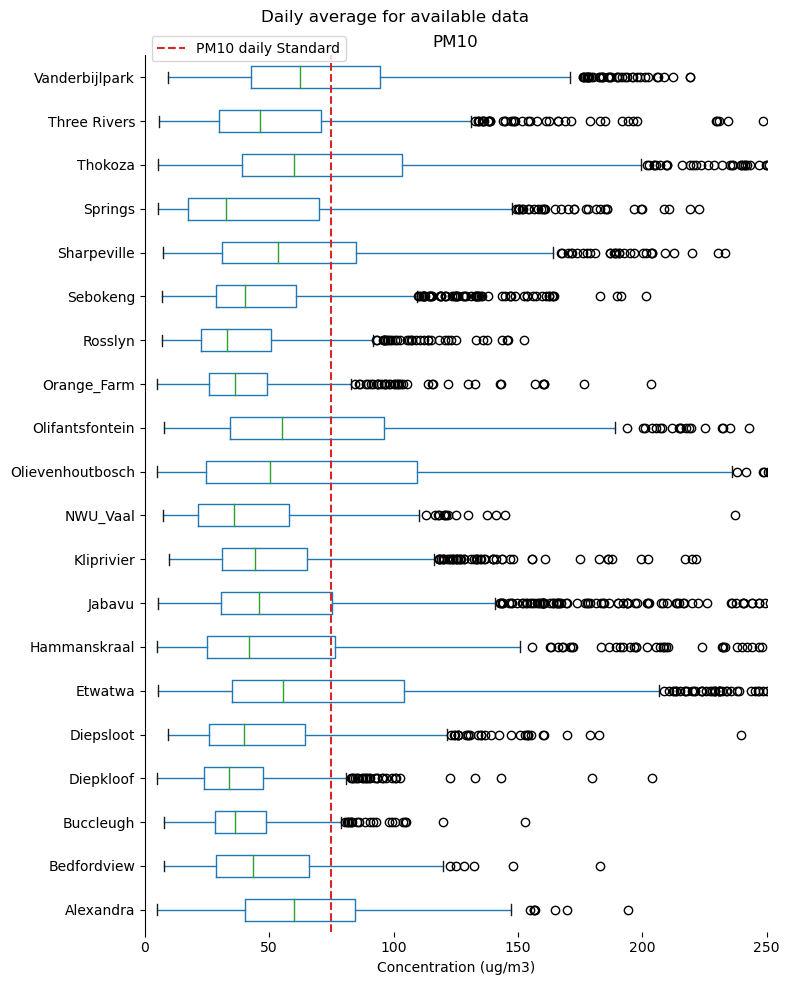

In [81]:
# Get daily averages from short format quickly
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='PM10')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
level_values=df4.index.get_level_values
df4=(df4.groupby([level_values(i) for i in [0]]+[pd.Grouper(freq='1D', level=-1)]).mean())
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='PM10').count()
usesites=list(goodsites[goodsites>500].index.values)
df4=df4[df4['Site'].isin(usesites)]

ax=df4.boxplot(column='PM10',by='Site', vert=False, figsize=(8,10), return_type='axes')
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_xlim(0,250)
ax[0].grid(False)
ax[0].set_xlabel("Concentration (ug/m3)")

(m,M)=ax[0].get_ylim()

plt.plot([75,75],[m,M], color='tab:red', label='PM10 daily Standard', linestyle='--') 
plt.legend(loc='upper left', bbox_to_anchor=(0,1.03))
plt.suptitle('Daily average for available data')
plt.tight_layout()
plt.savefig('GJA_PM10_daily.png', bbox_inches='tight',format='png', dpi=300)

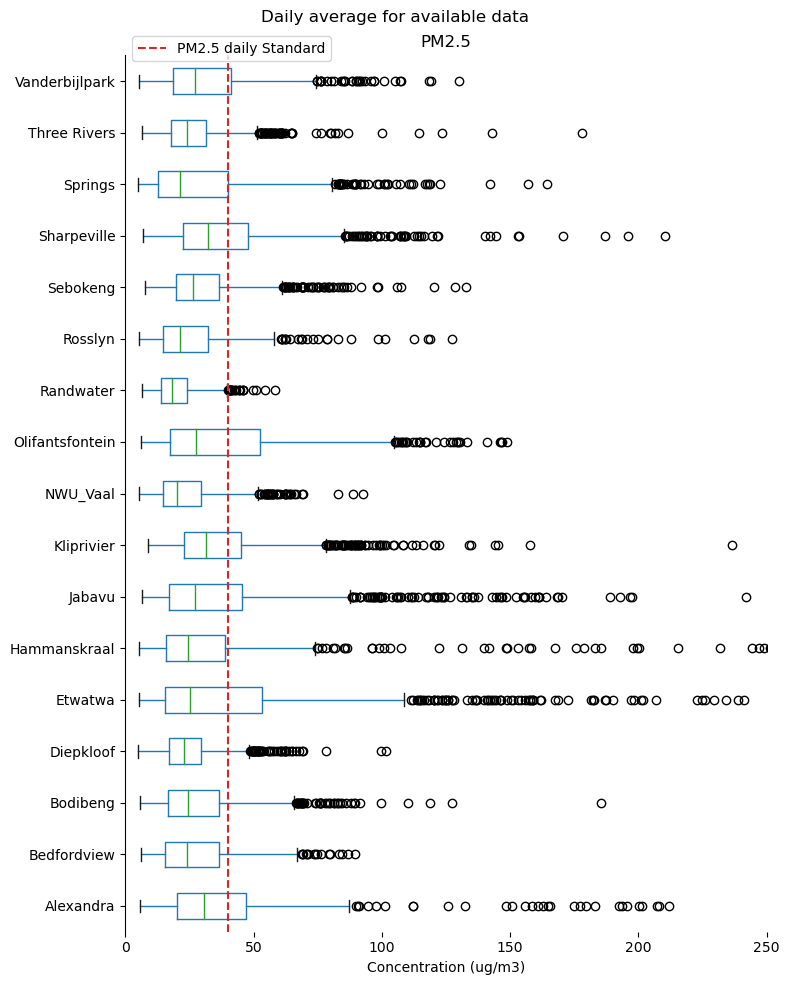

In [82]:
# Get daily averages from short format quickly
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='PM2.5')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
level_values=df4.index.get_level_values
df4=(df4.groupby([level_values(i) for i in [0]]+[pd.Grouper(freq='1D', level=-1)]).mean())
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='PM2.5').count()
usesites=list(goodsites[goodsites>500].index.values)
df4=df4[df4['Site'].isin(usesites)]

ax=df4.boxplot(column='PM2.5',by='Site', vert=False, figsize=(8,10), return_type='axes')
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_xlim(0,250)
ax[0].grid(False)
ax[0].set_xlabel("Concentration (ug/m3)")

(m,M)=ax[0].get_ylim()

plt.plot([40,40],[m,M], color='tab:red', label='PM2.5 daily Standard', linestyle='--') 
plt.legend(loc='upper left', bbox_to_anchor=(0,1.03))
plt.suptitle('Daily average for available data')
plt.tight_layout()
plt.savefig('GJA_PM25_daily.png', bbox_inches='tight',format='png', dpi=300)

In [86]:
usesites.remove('Booysens')

ValueError: list.remove(x): x not in list

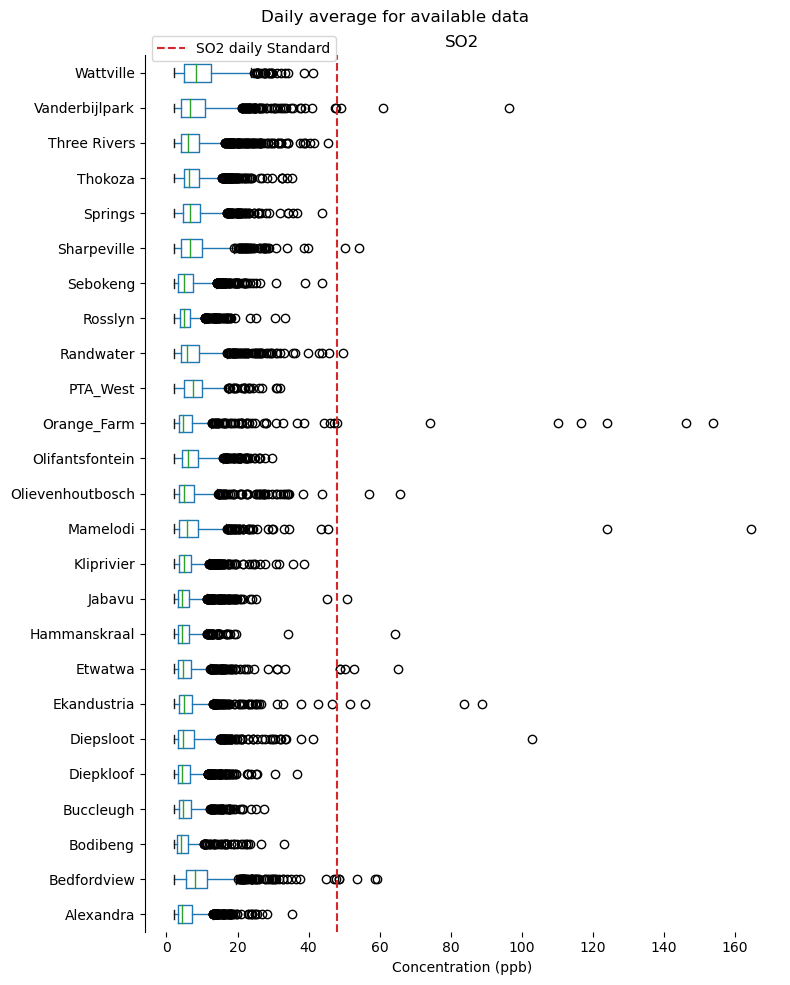

In [83]:
# Get daily averages from short format quickly
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='SO2')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
level_values=df4.index.get_level_values
df4=(df4.groupby([level_values(i) for i in [0]]+[pd.Grouper(freq='1D', level=-1)]).mean())
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='SO2').count()
usesites=list(goodsites[goodsites>500].index.values)
usesites.remove('Booysens')
df4=df4[df4['Site'].isin(usesites)]

ax=df4.boxplot(column='SO2',by='Site', vert=False, figsize=(8,10), return_type='axes')
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].spines["right"].set_visible(False)
#ax[0].set_xlim(0,50)
ax[0].grid(False)
ax[0].set_xlabel("Concentration (ppb)")

(m,M)=ax[0].get_ylim()

plt.plot([48,48],[m,M], color='tab:red', label='SO2 daily Standard', linestyle='--') 
plt.legend(loc='upper left', bbox_to_anchor=(0,1.03))
plt.suptitle('Daily average for available data')
plt.tight_layout()
plt.savefig('GJA_SO2_daily.png', bbox_inches='tight',format='png', dpi=300)

In [88]:
df4

Variable,Site,Date,SO2
0,Alexandra,2018-09-18,3.791875
1,Alexandra,2018-09-19,9.511375
2,Alexandra,2018-09-20,7.482333
3,Alexandra,2018-09-21,2.652375
4,Alexandra,2018-09-22,2.931833
...,...,...,...
31042,Wattville,2020-12-15,4.670312
31043,Wattville,2020-12-16,9.246111
31044,Wattville,2020-12-17,10.879625
31045,Wattville,2020-12-18,13.045389


In [84]:
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='SO2')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')

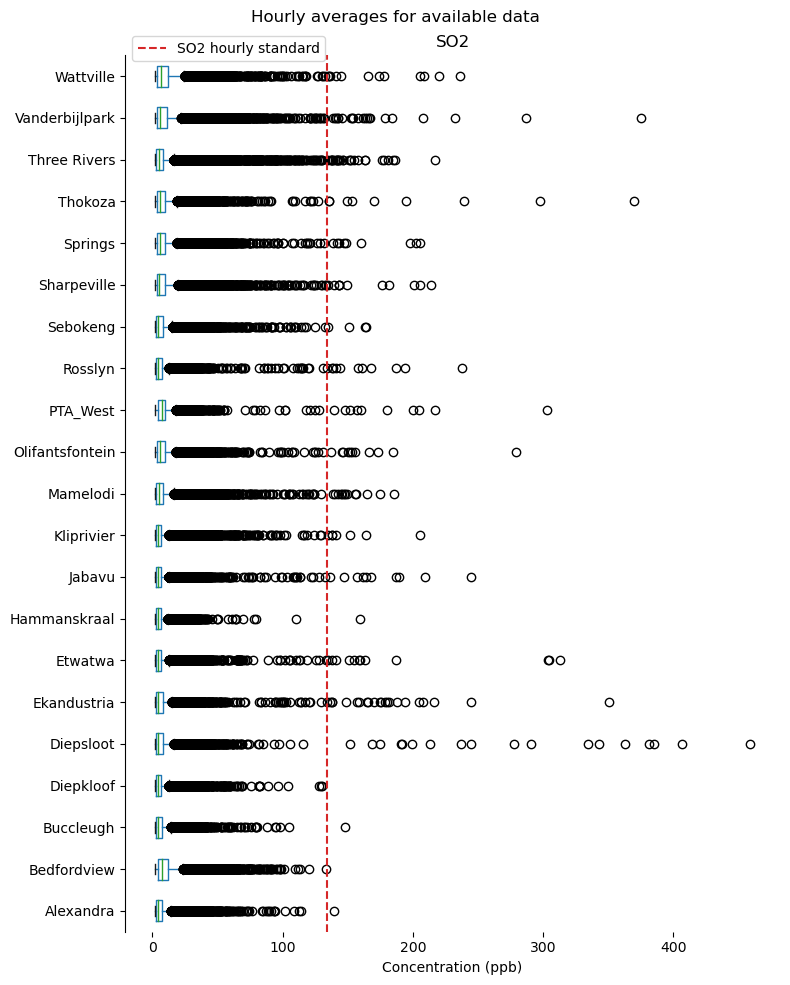

In [85]:
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='SO2')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='SO2').count()
usesites=list(goodsites[goodsites>10000].index.values)
usesites.remove('Booysens')
df4=df4[df4['Site'].isin(usesites)]

ax=df4.boxplot(column='SO2',by='Site', vert=False, figsize=(8,10), return_type='axes')
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].spines["right"].set_visible(False)
#ax[0].set_xlim(0,50)
ax[0].grid(False)
ax[0].set_xlabel("Concentration (ppb)")

(m,M)=ax[0].get_ylim()

plt.plot([134,134],[m,M], color='tab:red', label='SO2 hourly standard', linestyle='--') 
plt.legend(loc='upper left', bbox_to_anchor=(0,1.03))
plt.suptitle('Hourly averages for available data')
plt.tight_layout()
plt.savefig('GJA_SO2_hourly.png', bbox_inches='tight',format='png', dpi=300)

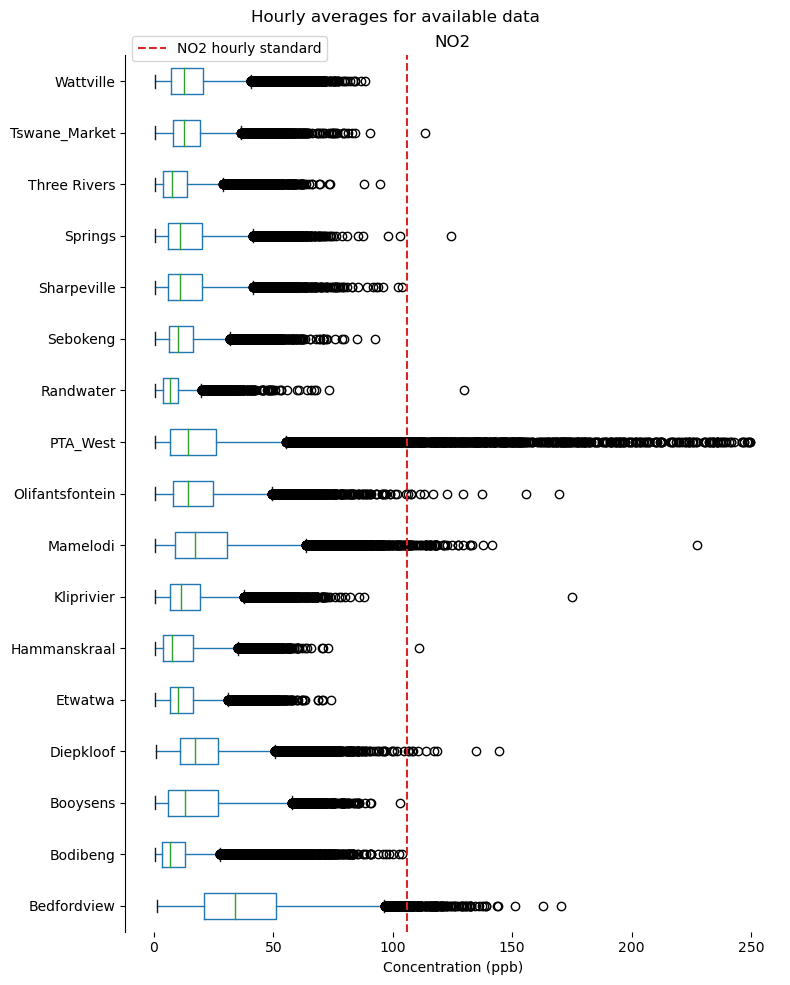

In [86]:
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='NO2')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='NO2').count()
usesites=list(goodsites[goodsites>10000].index.values)
df4=df4[df4['Site'].isin(usesites)]

ax=df4.boxplot(column='NO2',by='Site', vert=False, figsize=(8,10), return_type='axes')
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].spines["right"].set_visible(False)
#ax[0].set_xlim(0,50)
ax[0].grid(False)
ax[0].set_xlabel("Concentration (ppb)")

(m,M)=ax[0].get_ylim()

plt.plot([106,106],[m,M], color='tab:red', label='NO2 hourly standard', linestyle='--') 
plt.legend(loc='upper left', bbox_to_anchor=(0,1.03))
plt.suptitle('Hourly averages for available data')
plt.tight_layout()
plt.savefig('GJA_NO2_hourly.png', bbox_inches='tight',format='png', dpi=300)

In [87]:
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='NO2')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='NO2').count()
usesites=list(goodsites[goodsites>10000].index.values)
df4=df4[df4['Site'].isin(usesites)]
df4.groupby('Site')['NO2'].describe(percentiles=[0.5,0.75,0.99])

,count,mean,std,min,50%,75%,99%,max
Site,,,,,,,,
Bedfordview,19959.0,38.163553,22.383108,1.065,33.9860,51.06800,103.17582,170.654
Bodibeng,29922.0,11.086868,12.200528,0.502,6.7170,13.11700,58.44611,103.838
Booysens,27267.0,17.849839,14.852928,0.500,13.1080,26.67600,61.69094,103.039
Diepkloof,39215.0,20.552076,13.138790,0.818,17.0150,26.83250,63.39762,144.517
Etwatwa,17492.0,12.861631,9.032081,0.502,10.2075,16.39925,43.86836,74.141
Hammanskraal,16156.0,11.581397,10.808970,0.500,7.6375,16.16775,46.92500,110.843
Kliprivier,36033.0,14.262776,10.534282,0.512,11.4980,19.07200,49.81188,175.119
Mamelodi,16873.0,23.353501,20.307038,0.538,17.2210,30.65300,90.01400,227.288
Olifantsfontein,25295.0,17.980608,13.753474,0.501,14.0970,24.54050,63.02360,169.632


In [88]:
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='SO2')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='SO2').count()
usesites=list(goodsites[goodsites>10000].index.values)
df4=df4[df4['Site'].isin(usesites)]
df4.groupby('Site')['SO2'].describe(percentiles=[0.5,0.75,0.99])

,count,mean,std,min,50%,75%,99%,max
Site,,,,,,,,
Alexandra,13535.0,6.854314,7.884231,2.0,4.047,7.46550,39.18526,139.765
Bedfordview,22989.0,9.974691,9.475973,2.0,7.167,12.04500,48.87768,133.442
Booysens,25577.0,34.661011,60.217546,2.0,10.567,45.24400,352.57816,499.284
Buccleugh,11903.0,6.620209,6.640616,2.0,4.509,7.61800,32.54310,148.217
Diepkloof,27437.0,5.970673,5.646345,2.0,4.267,6.81500,28.39784,130.283
Diepsloot,15906.0,7.296086,11.887231,2.0,4.667,8.41700,36.82585,458.917
Ekandustria,13540.0,6.912432,10.302685,2.0,4.467,7.80000,36.36350,350.600
Etwatwa,15896.0,6.438314,8.972377,2.0,4.013,6.92400,36.12135,312.603
Hammanskraal,19639.0,5.390607,4.427245,2.0,4.017,6.46500,22.63608,159.750


In [89]:
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='SO2')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
level_values=df4.index.get_level_values
df4=(df4.groupby([level_values(i) for i in [0]]+[pd.Grouper(freq='1D', level=-1)]).mean())
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='SO2').count()
usesites=list(goodsites[goodsites>500].index.values)
df4=df4[df4['Site'].isin(usesites)]
df4.groupby('Site')['SO2'].describe(percentiles=[0.5,0.75,0.99])

,count,mean,std,min,50%,75%,99%,max
Site,,,,,,,,
Alexandra,942.0,5.982261,4.298946,2.000000,4.468473,7.150205,23.189763,35.209208
Bedfordview,1192.0,9.357756,6.196820,2.000000,7.966854,11.276021,32.784542,59.192333
Bodibeng,744.0,5.049232,3.431628,2.000000,4.030357,5.928618,20.456780,33.135200
Booysens,1333.0,35.035772,57.653442,2.017375,8.471958,45.700417,289.484585,442.507250
Buccleugh,773.0,5.802170,3.610165,2.017000,4.745455,6.900143,18.230642,27.308000
Diepkloof,1585.0,5.440188,3.428634,2.004000,4.447091,6.514429,17.718395,36.780500
Diepsloot,947.0,6.590544,5.989779,2.000000,4.750000,7.800667,29.861820,102.982500
Ekandustria,871.0,6.535935,6.468687,2.000000,5.000842,7.294767,27.978930,88.866500
Etwatwa,1137.0,5.844977,4.889099,2.000000,4.586875,6.814333,22.163497,65.096000


In [95]:
df4

Variable,Site,Date,SO2
0,Alexandra,2018-09-18,3.791875
1,Alexandra,2018-09-19,9.511375
2,Alexandra,2018-09-20,7.482333
3,Alexandra,2018-09-21,2.652375
4,Alexandra,2018-09-22,2.931833
...,...,...,...
31042,Wattville,2020-12-15,4.670312
31043,Wattville,2020-12-16,9.246111
31044,Wattville,2020-12-17,10.879625
31045,Wattville,2020-12-18,13.045389


In [96]:
df4.groupby('Site')['NO2'].describe(percentiles=[0.5,0.75,0.99])

KeyError: 'Column not found: NO2'

In [90]:
# Get daily averages from short format quickly
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='SO2')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='PM10').count()
usesites=list(goodsites[goodsites>500].index.values)
df4=df4[df4['Site'].isin(usesites)]

ax=df4.boxplot(column='PM10',by='Site', vert=False, figsize=(8,10), return_type='axes')
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_xlim(0,250)
ax[0].grid(False)
ax[0].set_xlabel("Concentration (ug/m3)")

(m,M)=ax[0].get_ylim()

plt.plot([75,75],[m,M], color='tab:red', label='PM10 daily Standard', linestyle='--') 
plt.legend(loc='upper left', bbox_to_anchor=(0,1.03))
plt.suptitle('Daily average for available data')
plt.tight_layout()

KeyError: 'PM10'

In [ ]:
df4.index

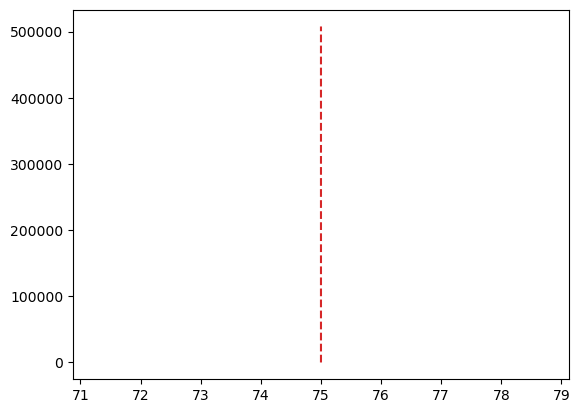

In [98]:
plt.plot([75 for x in df4.index],df4.index, color='tab:red', label='PM10 Standard', linestyle='--') 

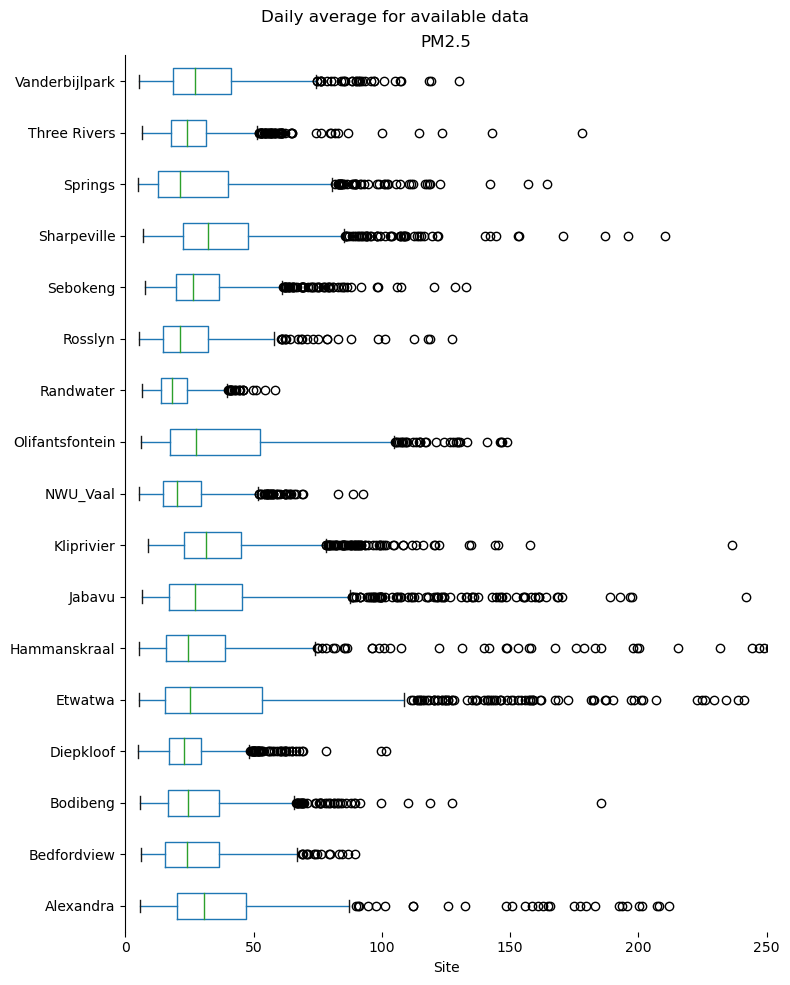

In [99]:
# Get daily averages from short format quickly
df4=pd.pivot_table(dfRaw[(dfRaw['Status']==0)&(dfRaw['Variable']=='PM2.5')&(dfRaw['Authority']=='GJA')],index=['Site','Date'],columns=['Variable'],values='Value')
level_values=df4.index.get_level_values
df4=(df4.groupby([level_values(i) for i in [0]]+[pd.Grouper(freq='1D', level=-1)]).mean())
df4=df4.reset_index()
goodsites=pd.pivot_table(df4,index='Date',columns=['Site'],values='PM2.5').count()
usesites=list(goodsites[goodsites>500].index.values)
df4=df4[df4['Site'].isin(usesites)]

ax=df4.boxplot(column='PM2.5',by='Site', vert=False, figsize=(8,10), return_type='axes')
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_xlim(0,250)
ax[0].grid(False)
plt.suptitle('Daily average for available data')
plt.tight_layout()

In [100]:
ax

PM2.5    AxesSubplot(0.162778,0.0582778;0.801832x0.876389)
dtype: object

In [101]:
level_values=df4.index.get_level_values
(df4.groupby([level_values(i) for i in [0]]+[pd.Grouper(freq='1D', level=-1)]).mean())

ValueError: The level -1 is not valid

In [102]:
level_values

<bound method Index._get_level_values of Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            18326, 18327, 18328, 18329, 18330, 18331, 18332, 18333, 18334,
            18335],
           dtype='int64', length=16637)>

In [103]:
[level_values(i) for i in [0]]

[Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                 9,
             ...
             18326, 18327, 18328, 18329, 18330, 18331, 18332, 18333, 18334,
             18335],
            dtype='int64', length=16637)]

In [104]:
(df4.groupby([level_values(i) for i in [0]]+[pd.Grouper(freq='1D', level=-1)]).mean())

ValueError: The level -1 is not valid

In [105]:
level_values = df4.index.get_level_values
result = (df.groupby([level_values(i) for i in [0,1]]
                      +[pd.Grouper(freq='2D', level=-1)]).sum())

IndexError: Too many levels: Index has only 1 level, not 2

In [106]:
dfRaw['Date']

 7860320140776357163   2017-10-01 01:00:00
-1965297985333058308   2017-10-01 01:00:00
-7485172957009719073   2017-10-01 01:00:00
 3300082397400872614   2017-10-01 01:00:00
-2307915222332187378   2017-10-01 01:00:00
                               ...        
-4098372955092856511   2020-10-01 00:00:00
-4689913369471851562   2020-10-01 00:00:00
 3712785171364353304   2020-10-01 00:00:00
 6360184204476554464   2020-10-01 00:00:00
 7066471988687593588   2020-10-01 00:00:00
Name: Date, Length: 7986829, dtype: datetime64[ns]

## Bivariate polar plots

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))
/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecatio

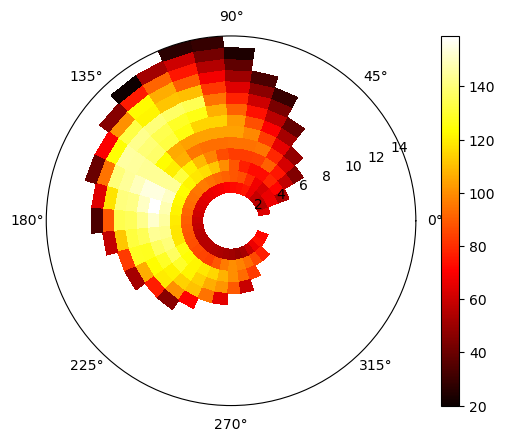

In [107]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

wd = [90, 297, 309, 336, 20, 2, 334, 327, 117, 125, 122, 97, 95, 97, 103, 106, 125, 148, 147, 140, 141, 145, 144, 151, 161]
ws = [15, 1.6, 1.8, 1.7, 2.1, 1.6, 2.1, 1.4, 3, 6.5, 7.1, 8.2, 10.2, 10.2, 10.8, 10.2, 11.4, 9.7, 8.6, 7.1, 6.4, 5.5, 5, 5, 6]
oz = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 90, 140, 100, 106, 125, 148, 147, 140, 141, 145, 144, 151, 161]
wd_rad = np.radians(np.array(wd))
oz = np.array(oz, dtype=np.float)


WD, WS = np.meshgrid(np.linspace(0, 2*np.pi, 36), np.linspace(min(ws), max(ws), 16 ))
Z = interpolate.griddata((wd_rad, ws), oz, (WD, WS), method='linear')

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
cmap = plt.get_cmap('hot')
cmap.set_under('none')
img = ax.pcolormesh(WD, WS, Z, cmap=cmap, vmin=20)
plt.colorbar(img)
plt.show()

In [108]:
# Define the settings for the windrose that is being created.
def plot_ppollrose(dfc,WD="WindDir",WS="WindSpeed",CO="PM10",title="",output=Path("polar.png")):                                                                                                                                                                                                                                                   
    dfc=dfc[[WD,WS,CO]].dropna()
    wd_rad = np.radians(np.array(dfc[WD]))
    Conc = np.array(dfc[CO], dtype=float)
    WSmax = max(dfc[WS])
    WD1, WS1 = np.meshgrid(np.linspace(0, 2*np.pi, 360), np.linspace(min(dfc[WS]), max(dfc[WS]), 16))
    Z = interpolate.griddata((wd_rad, dfc[WS]), dfc[CO], (WD1, WS1), method='linear')

    levels = MaxNLocator(nbins=10).tick_values(0, 500)
    
    cmap = plt.get_cmap('viridis')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    fig, ax = plt.subplots(figsize=(4,4), subplot_kw={"projection": "polar"})
    
    img = ax.pcolormesh(WD1, WS1, Z, cmap=cmap, norm=norm, edgecolor='none', linewidth=0, alpha=1, shading='nearest', snap='bool', capstyle='round')
    
    cbar = plt.colorbar(img, cax=None, ax=None, use_gridspec=True, orientation='vertical', drawedges=True, pad=0.09, shrink=0.5)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(CO,size=10, labelpad=+10 )
    
    #To display the grid in the background.
    ax.grid(True)
    # Specify different settings for major and minor grids
    #ax.grid(which = 'minor', alpha = 0.3)
    #ax.grid(which = 'major', alpha = 0.7)
    
    major_yticks = np.arange(0, 15, step=2.5)
    #minor_yticks = np.arange(0, 15, step=0.5)
    #major_xticks = np.arange(0, 8, step=360)
    #minor_xticks = np.arange(0, 360, step=22.5)
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10, width=1.5, direction='out', pad=0.8, labelrotation=0, top=True, grid_color='white', grid_linewidth=1)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 0)
    
    ax.set_yticks(major_yticks)
    ax.set_ylim([0,WSmax])
    #ax.set_yticks(minor_yticks, minor=True)
    #ax.set_xticks(major_xticks)
    #ax.set_xticks(minor_xticks, minor=True)
   
    # To rename the x-axis from Degrees to Directions.
    ax.set_xticklabels(['N', 'N-E', 'E', 'S-E', 'S', 'S-W', 'W', 'N-W'], fontsize=10)
       
    # To move the 0 Deg from the E-point to the N-point.
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    
    ax.set_axisbelow(False)
    fig.suptitle(title)
    plt.tight_layout()
    #plt.savefig(output,dpi=300, bbox_inches = "tight")  
    plt.show()
    #plt.close()

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


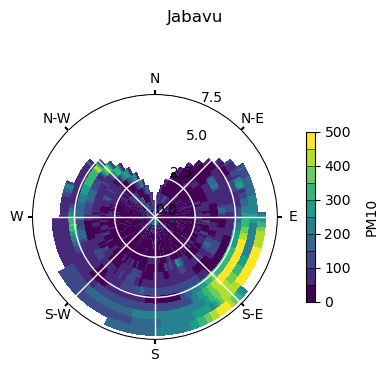

In [112]:
plot_ppollrose(dftmp,CO='PM10', title='Jabavu')

In [113]:
Stations

array(['Alexandra', 'Bedfordview', 'Bodibeng', 'Booysens', 'Buccleugh',
       'Diepkloof', 'Diepsloot', 'Ekandustria', 'Etwatwa', 'Hammanskraal',
       'Ivory_park', 'Jabavu', 'Kliprivier', 'Leondale_City', 'Mamelodi',
       'Meyerton', 'Mogale_City', 'NWU_Vaal', 'Olievenhoutbosch',
       'Olifantsfontein', 'Orange_Farm', 'PTA_West', 'Randfontein',
       'Randwater', 'Rosslyn', 'Sebokeng', 'Sharpeville', 'Springs',
       'Springs-new', 'Tembisa', 'Thokoza', 'Three Rivers', 'Tsakane',
       'Tswane_Market', 'Vanderbijlpark', 'Wattville'], dtype=object)

# GJA analysis

In [50]:
Sites

NameError: name 'Sites' is not defined

In [115]:
dfRaw[dfRaw['Authority']=='GJA']['Site'].unique()

array(['Diepkloof', 'Kliprivier', 'Sebokeng', 'Sharpeville',
       'Three Rivers', 'Etwatwa', 'Olifantsfontein', 'Springs', 'Tsakane',
       'Wattville', 'Booysens', 'Ekandustria', 'Mamelodi', 'Rosslyn',
       'Bodibeng', 'Mogale_City', 'Olievenhoutbosch', 'PTA_West',
       'Hammanskraal', 'Thokoza', 'Tswane_Market', 'Randwater',
       'Bedfordview', 'Buccleugh', 'Tembisa', 'Randfontein',
       'Leondale_City', 'Jabavu', 'Meyerton', 'Vanderbijlpark',
       'Diepsloot', 'Springs-new', 'Orange_Farm', 'Alexandra', 'NWU_Vaal',
       'Ivory_park'], dtype=object)

In [116]:
dfGJA=dfRaw[dfRaw["Site"].str.contains('(Jabavu|Diepkloof|Springs|Olifantsfontein)', regex=True)]

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [117]:
dfGJA['Site'].unique()

array(['Diepkloof', 'Olifantsfontein', 'Springs', 'Jabavu', 'Springs-new'],
      dtype=object)

In [93]:
GJAsites=['Diepkloof', 'Jabavu', 'Olifantsfontein','Springs', 'Springs-new',
          'Kliprivier', 'Sebokeng', 'Sharpeville',
           'Three Rivers', 'Etwatwa', 'Olifantsfontein', 'Tsakane',
           'Wattville', 'Booysens', 'Ekandustria', 'Rosslyn',
           'Bodibeng', 'Mogale_City', 'Olievenhoutbosch', 'PTA_West',
           'Hammanskraal', 'Thokoza', 'Tswane_Market', 'Randwater',
           'Bedfordview', 'Buccleugh', 'Tembisa', 'Randfontein',
           'Leondale_City', 'Meyerton', 'Vanderbijlpark',
           'Diepsloot', 'Orange_Farm', 'Alexandra', 'NWU_Vaal',
           'Ivory_park']

In [94]:
Threshold=65
Data=[]
for s in GJAsites:
    for v in ['PM10','PM2.5']:
        df=extractStation(dfRaw,v,s,Status=0)
        # Daily averages
        tThres=df['Value'].dropna().quantile(0.99)
        tValue=df['Value'].dropna().resample('1D').mean()
        tCount=df['Value'].dropna().resample('1D').count()
        tDaily=pd.concat([tValue,tCount],axis=1)
        tDaily.columns=['Mean','N']
        tDaily.loc[tDaily['N']/24*100<Threshold,'Mean']=np.nan

        # Monthly averages
        tValue=tDaily['Mean'].dropna().resample('1M').mean()
        tCount=tDaily['Mean'].dropna().resample('1M').count()
        tMonthly=pd.concat([tValue,tCount],axis=1)
        tMonthly.columns=['Mean','N']
        tMonthly.loc[tMonthly['N']/tMonthly.index.days_in_month*100<Threshold,'Mean']=np.nan

        # Annual average
        tValue=tMonthly['Mean'].dropna().resample('1Y').mean()
        tCount=tMonthly['Mean'].dropna().resample('1Y').count()
        tAnnual=pd.concat([tValue,tCount],axis=1)
        tAnnual.columns=['Mean','N']
        tAnnual.loc[tAnnual['N']/12*100<Threshold,'Mean']=np.nan

        #
        if len(tAnnual['Mean'].dropna()) > 0:
            Data.append([s,v,tAnnual['Mean'].mean(),tAnnual['Mean'].count()])
        else:
            tMonthly['Month']=tMonthly.index.month
            tMonthly=tMonthly.groupby('Month').mean()[['Mean']]
            if tMonthly['Mean'].count()/12*100>Threshold:
                Data.append([s,v,tMonthly['Mean'].mean(),tMonthly['Mean'].count()])
    

dfAnn=pd.pivot_table(pd.DataFrame(data=Data, columns=['Site','Variable','Annual','N']),index='Site',columns='Variable',values=['Annual','N'])
dfAnn

Annual                N      
Variable               PM10      PM2.5  PM10 PM2.5
Site                                              
Alexandra         69.000843  35.930254   1.0   1.0
Bedfordview       48.984103  27.646535   3.0   3.0
Bodibeng          69.062161  30.225458  10.0   1.0
Booysens          72.324412        NaN  10.0   NaN
Buccleugh         41.742300        NaN   8.0   NaN
Diepkloof         37.803183  24.196835   5.0   3.0
Diepsloot         43.107692        NaN   2.0   NaN
Etwatwa           98.780250  52.327086   2.0   2.0
Hammanskraal      63.237761  26.819970   1.0   1.0
Ivory_park        49.146207        NaN  11.0   NaN
Jabavu            66.961013  40.984532   4.0   3.0
Kliprivier        56.798591  38.340758   3.0   2.0
NWU_Vaal          44.171942  26.236204   2.0   2.0
Olievenhoutbosch  97.224015  38.684320  10.0   1.0
Olifantsfontein   70.700723  33.903615   2.0   2.0
Orange_Farm       42.971296        NaN  11.0   NaN
PTA_West          29.572599        NaN   1.0   NaN
Randwater               NaN  21.012719   NaN  11.0
Rosslyn           33.412865  25.575655   2.0   1.0
Sebokeng          39.084772  31.259781   1.0   1.0
Sharpeville       57.828645  36.579435   1.0   1.0
Springs           39.628488  32.416056   2.0   1.0
Thokoza           93.881687        NaN   2.0   NaN
Three Rivers      61.341365  27.507806   3.0   3.0
Tswane_Market     47.084085  35.883437   1.0   1.0
Vanderbijlpark    69.430570  30.752688   4.0   2.0

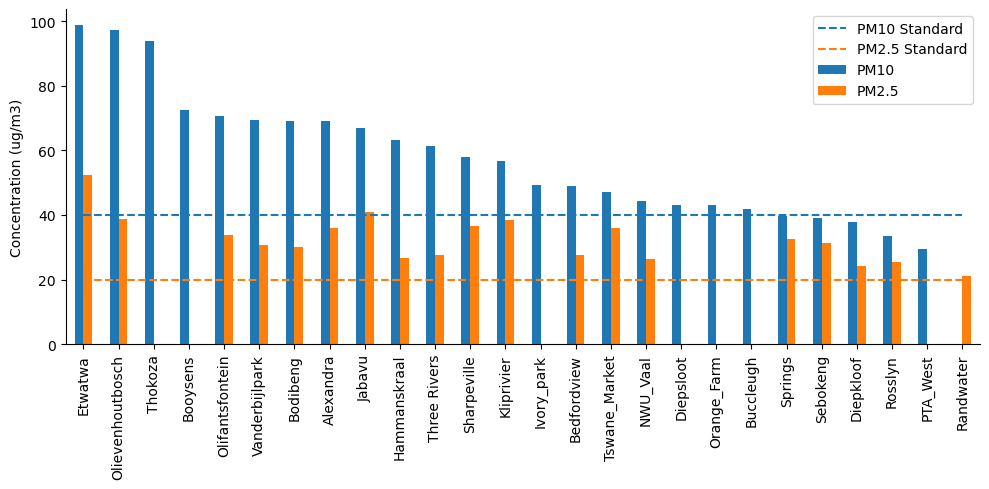

In [95]:
dfAnn.sort_values(('Annual','PM10'), ascending=False, inplace=True)
ax=dfAnn['Annual'].plot(kind='bar',figsize=(10,5))

plt.plot(dfAnn.index, [40 for x in dfAnn.index], color='tab:blue', label='PM10 Standard', linestyle='--') 
plt.plot(dfAnn.index, [20 for x in dfAnn.index], color='tab:orange', label='PM2.5 Standard', linestyle='--') 

plt.legend()
ax.spines["top"].set_visible(False)
#ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Concentration (ug/m3)")
ax.set_xlabel("")

#ax.set_xlim(0,250)
ax.grid(False)
plt.tight_layout()
plt.savefig('GJA_PM_annual.png', bbox_inches='tight',format='png', dpi=300)

In [97]:
pd.options.display.float_format = '{:,.0f}'.format
dfAnn.fillna('')

Annual          N      
Variable           PM10 PM2.5 PM10 PM2.5
Site                                    
Etwatwa              99    52    2     2
Olievenhoutbosch     97    39   10     1
Thokoza              94          2      
Booysens             72         10      
Olifantsfontein      71    34    2     2
Vanderbijlpark       69    31    4     2
Bodibeng             69    30   10     1
Alexandra            69    36    1     1
Jabavu               67    41    4     3
Hammanskraal         63    27    1     1
Three Rivers         61    28    3     3
Sharpeville          58    37    1     1
Kliprivier           57    38    3     2
Ivory_park           49         11      
Bedfordview          49    28    3     3
Tswane_Market        47    36    1     1
NWU_Vaal             44    26    2     2
Diepsloot            43          2      
Orange_Farm          43         11      
Buccleugh            42          8      
Springs              40    32    2     1
Sebokeng             39    31    1     1
Diepkloof            38    24    5     3
Rosslyn              33    26    2     1
PTA_West             30          1      
Randwater                  21         11

In [118]:
len(df['2017'])

KeyError: '2017'

In [158]:
df['Value'].dropna().quantile(0.99)

nan

In [160]:
int(10<5)

0

# Check compliance

In [161]:
for s in Sites:
    print(",{},,,".format(s),end="")

,Alexandra,,,,Bedfordview,,,,Bodibeng,,,,Booysens,,,,Buccleugh,,,,Diepkloof,,,,Diepsloot,,,,Ekandustria,,,,Etwatwa,,,,Hammanskraal,,,,Ivory_park,,,,Jabavu,,,,Kliprivier,,,,Leondale_City,,,,Mamelodi,,,,Meyerton,,,,Mogale_City,,,,NWU_Vaal,,,,Olievenhoutbosch,,,,Olifantsfontein,,,,Orange_Farm,,,,PTA_West,,,,Randfontein,,,,Randwater,,,,Rosslyn,,,,Sebokeng,,,,Sharpeville,,,,Springs,,,,Springs-new,,,,Tembisa,,,,Thokoza,,,,Three Rivers,,,,Tsakane,,,,Tswane_Market,,,,Vanderbijlpark,,,,Wattville,,,

In [162]:
int(10>5)

1

In [168]:
# 0 above 70% and no exceedances
# -1 not 70% data recovery
# 1 exceeds hourly
# 2 exceeds daily
# 3 exceeds hourly and daily
# 4 exceeds annual
# 5 exceeds hourly and annual
# 6 exceeds daily and annual
# 7 exceeds hourly, daily, and annual

vars=['SO2','NO2','PM10','PM2.5']
standard=[[134,48,19],[106,0,21],[0,75,40],[0,40,20]]
for s in Sites:
    print(",{}".format(s),end="")
print("")
for v in range(len(vars)):
    print(vars[v])
    print("",end="")
    for y in range(2017,2021):
        print(y,end="")
        for s in Sites:
            df=extractStation(dfRaw,vars[v],s,Status=0)
            df=df[['Value']]
            try:
                dfy=df['{}-01-01'.format(y):'{}-12-31'.format(y)]

                # is there an hourly standard
                if standard[v][0] > 0:
                    HDA=len(dfy['Value'].dropna())/(365*24)*100
                    HComply=dfy['Value'].dropna().quantile(0.99)>standard[v][0]
                else:
                    HDA=len(dfy['Value'].dropna())/(365*24)*100
                    HComply=False

                # is there an daily standard
                if standard[v][1] > 0:
                    DDA=len(dfy['Value'].dropna().resample('1D').mean())/365*100
                    DComply=dfy['Value'].dropna().resample('1D').mean().quantile(0.99)>standard[v][1]
                else:
                    DDA=len(dfy['Value'].dropna().resample('1D').mean())/365*100
                    DComply=False

                # is there an annual standard
                if standard[v][2] > 0:
                    AComply=dfy['Value'].mean()>standard[v][2]
                else:
                    AComply=False

                if HDA < DDA:
                    DA=HDA
                else:
                    DA=DDA

                index=0
                if HComply and not DComply and not AComply:
                    index=1
                if DComply and not HComply and not AComply:
                    index=2
                if HComply and DComply and not AComply:
                    index=3
                if AComply and not HComply and not DComply:
                    index=4
                if HComply and AComply and not DComply:
                    index=5
                if DComply and AComply and not HComply:
                    index=6
                if HComply and DComply and AComply:
                    index=7

                if DA< 70 and index==0:
                    index=-10
                if DA<70 and index>0:
                    index=index*-1

                print(",{:.0f}".format(index), end="")

                #break
                #print(y,s)
            except:
                print(",-10", end="")
        print("")



,Alexandra,Bedfordview,Bodibeng,Booysens,Buccleugh,Diepkloof,Diepsloot,Ekandustria,Etwatwa,Hammanskraal,Ivory_park,Jabavu,Kliprivier,Leondale_City,Mamelodi,Meyerton,Mogale_City,NWU_Vaal,Olievenhoutbosch,Olifantsfontein,Orange_Farm,PTA_West,Randfontein,Randwater,Rosslyn,Sebokeng,Sharpeville,Springs,Springs-new,Tembisa,Thokoza,Three Rivers,Tsakane,Tswane_Market,Vanderbijlpark,Wattville
SO2
2017,-10,-2,-10,-10,-10,-10,-10,-2,-10,-10,-10,-10,-10,-10,-2,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
2018,-10,-10,-10,-2,-10,-10,-10,-10,-2,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,0,-10,-10,-10,-10,-10,0,-10,-10,0
2019,-10,0,-10,-7,-10,0,-10,-10,-10,-10,-10,-10,-10,-10,-10,-6,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,0,-10,-10,-10,-10,-10,-6,-10,-10,-10
2020,-10,0,-10,7,-10,-10,-10,-10,-10,-10,-10,-10,0,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-6,-10,-10
NO2
2017,-10,-4,-10,-10,-10,4,-10,-10,-1

In [130]:
dfy

Series([], Freq: H, Name: Value, dtype: float64)

In [ ]:
Threshold=65
Data=[]
for s in GJAsites:
    for v in ['PM10','PM2.5']:
        df=extractStation(dfRaw,v,s,Status=0)
        # Daily averages
        tThres=df['Value'].dropna().quantile(0.99)
        tValue=df['Value'].dropna().resample('1D').mean()
        tCount=df['Value'].dropna().resample('1D').count()
        tDaily=pd.concat([tValue,tCount],axis=1)
        tDaily.columns=['Mean','N']
        tDaily.loc[tDaily['N']/24*100<Threshold,'Mean']=np.nan

        # Monthly averages
        tValue=tDaily['Mean'].dropna().resample('1M').mean()
        tCount=tDaily['Mean'].dropna().resample('1M').count()
        tMonthly=pd.concat([tValue,tCount],axis=1)
        tMonthly.columns=['Mean','N']
        tMonthly.loc[tMonthly['N']/tMonthly.index.days_in_month*100<Threshold,'Mean']=np.nan

        # Annual average
        tValue=tMonthly['Mean'].dropna().resample('1Y').mean()
        tCount=tMonthly['Mean'].dropna().resample('1Y').count()
        tAnnual=pd.concat([tValue,tCount],axis=1)
        tAnnual.columns=['Mean','N']
        tAnnual.loc[tAnnual['N']/12*100<Threshold,'Mean']=np.nan

        #
        if len(tAnnual['Mean'].dropna()) > 0:
            Data.append([s,v,tAnnual['Mean'].mean(),tAnnual['Mean'].count()])
        else:
            tMonthly['Month']=tMonthly.index.month
            tMonthly=tMonthly.groupby('Month').mean()[['Mean']]
            if tMonthly['Mean'].count()/12*100>Threshold:
                Data.append([s,v,tMonthly['Mean'].mean(),tMonthly['Mean'].count()])
    

dfAnn=pd.pivot_table(pd.DataFrame(data=Data, columns=['Site','Variable','Annual','N']),index='Site',columns='Variable',values=['Annual','N'])
dfAnn

/tmp/ipykernel_13387/3726143079.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2018'].plot()


<AxesSubplot:xlabel='Date'>

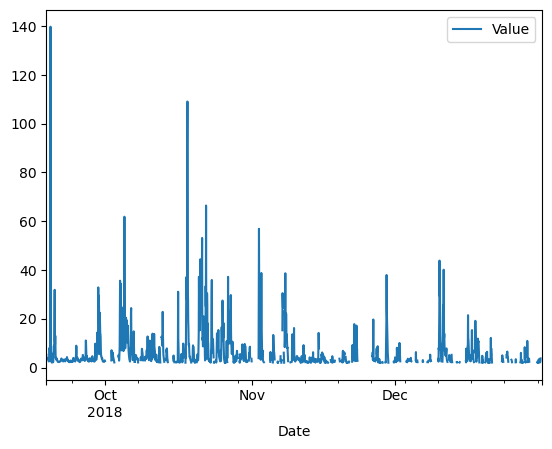

In [116]:
df['2018'].plot()

In [109]:
D = Diepkloof; K = Kliprivier; Se = Sebokeng; T = Three Rivers; Sh =Sharpeville; Zamdela; Randwater; Eco Park AJ Jacobs; Leitrim

SyntaxError: invalid syntax. Perhaps you forgot a comma? (50192842.py, line 1)

In [ ]:
Threshold=65
Data=[]
for s in GJAsites:
    for v in ['PM10','PM2.5']:
        df=extractStation(dfRaw,v,s,Status=0)
        # Daily averages
        tThres=df['Value'].dropna().quantile(0.99)
        tValue=df['Value'].dropna().resample('1D').mean()
        tCount=df['Value'].dropna().resample('1D').count()
        tDaily=pd.concat([tValue,tCount],axis=1)
        tDaily.columns=['Mean','N']
        tDaily.loc[tDaily['N']/24*100<Threshold,'Mean']=np.nan

        # Monthly averages
        tValue=tDaily['Mean'].dropna().resample('1M').mean()
        tCount=tDaily['Mean'].dropna().resample('1M').count()
        tMonthly=pd.concat([tValue,tCount],axis=1)
        tMonthly.columns=['Mean','N']
        tMonthly.loc[tMonthly['N']/tMonthly.index.days_in_month*100<Threshold,'Mean']=np.nan

        # Annual average
        tValue=tMonthly['Mean'].dropna().resample('1Y').mean()
        tCount=tMonthly['Mean'].dropna().resample('1Y').count()
        tAnnual=pd.concat([tValue,tCount],axis=1)
        tAnnual.columns=['Mean','N']
        tAnnual.loc[tAnnual['N']/12*100<Threshold,'Mean']=np.nan

        #
        if len(tAnnual['Mean'].dropna()) > 0:
            Data.append([s,v,tAnnual['Mean'].mean(),tAnnual['Mean'].count()])
        else:
            tMonthly['Month']=tMonthly.index.month
            tMonthly=tMonthly.groupby('Month').mean()[['Mean']]
            if tMonthly['Mean'].count()/12*100>Threshold:
                Data.append([s,v,tMonthly['Mean'].mean(),tMonthly['Mean'].count()])
    

dfAnn=pd.pivot_table(pd.DataFrame(data=Data, columns=['Site','Variable','Annual','N']),index='Site',columns='Variable',values=['Annual','N'])
dfAnn

## Jabavu

In [122]:
Campaigns=[['2021-04-21','2021-05-29'],['2021-06-27','2021-08-20']]

In [123]:
dftmp=extractStationVars(dfRaw,Site='Jabavu')
dftmp.tail()

Variable,O3,PM10,PM2.5,RH,SO2,SolarRadiation,Temperature,WindDir,WindSpeed
Date,,,,,,,,,
2021-10-02 08:00:00,nan,nan,nan,98,nan,27,16,271,1
2021-10-02 09:00:00,nan,nan,nan,98,nan,87,17,274,2
2021-10-02 10:00:00,nan,nan,nan,98,nan,60,17,288,2
2021-10-02 11:00:00,nan,nan,nan,98,nan,93,17,301,2
2021-10-02 12:00:00,nan,nan,nan,97,nan,456,20,292,2


In [124]:
dftmp[Campaigns[0][0]:Campaigns[0][1]]

Variable,O3,PM10,PM2.5,RH,SO2,SolarRadiation,Temperature,WindDir,WindSpeed
Date,,,,,,,,,
2021-04-21 00:00:00,8,175,106,62,nan,0,16,44,1
2021-04-21 01:00:00,11,122,71,64,nan,0,16,29,nan
2021-04-21 02:00:00,17,38,20,70,nan,0,15,59,1
2021-04-21 03:00:00,19,37,19,76,nan,0,15,65,nan
2021-04-21 04:00:00,15,36,19,90,nan,0,14,61,nan
...,...,...,...,...,...,...,...,...,...
2021-05-29 19:00:00,6,220,117,26,12,0,17,nan,nan
2021-05-29 20:00:00,3,134,78,30,17,0,15,nan,nan
2021-05-29 21:00:00,3,169,106,31,8,0,15,nan,nan


4


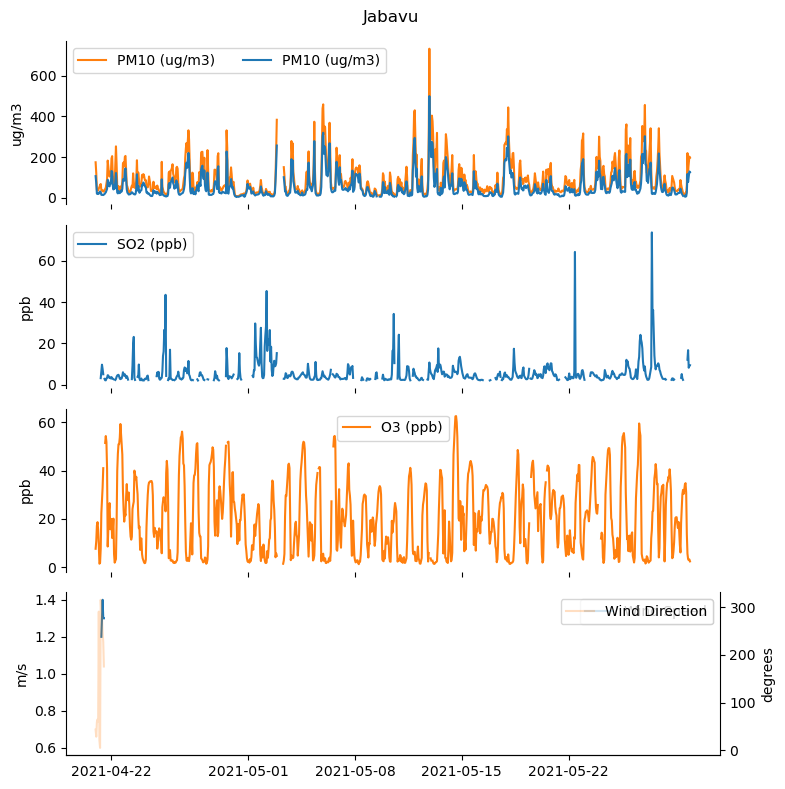

In [125]:
plotTimeSeries(dftmp[Campaigns[0][0]:Campaigns[0][1]],title="Jabavu")

In [379]:
plotTimeSeriesPeriod(dftmp,start=Campaigns[0][0], end=Campaigns[0][1], title="Jabavu Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [380]:
plotTimeSeriesPeriod(dftmp,start=Campaigns[1][0], end=Campaigns[1][1], title="Jabavu Winter Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [399]:
plotTimeSeries(dftmp[Campaigns[0][0]:Campaigns[0][1]],title="Jabavu Autumn Campaign")

4


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [400]:
plotTimeSeries(dftmp[Campaigns[1][0]:Campaigns[1][1]],title="Jabavu Winter Campaign")

4


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [416]:
plot_ppollrose(dftmp[Campaigns[0][0]:Campaigns[0][1]],CO='PM10', title="Jabavu Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


In [418]:
plot_ppollrose(dftmp[Campaigns[0][0]:Campaigns[0][1]],CO='PM2.5', title="Jabavu Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


In [417]:
plot_ppollrose(dftmp[Campaigns[1][0]:Campaigns[1][1]],CO='PM10', title="Jabavu Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


In [419]:
plot_ppollrose(dftmp[Campaigns[1][0]:Campaigns[1][1]],CO='PM2.5', title="Jabavu Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


## Diepkloof

In [420]:
Campaigns=[['2021-04-21','2021-05-29'],['2021-07-31','2021-08-28']]

In [421]:
dftmp=extractStationVars(dfRaw,Site='Diepkloof')
dftmp.head()

Variable,CO,NO,NO2,NOx,O3,PM10,PM2.5,RH,SO2,SolarRadiation,Temperature,WindDir,WindSpeed
Date,,,,,,,,,,,,,
2016-01-01 01:00:00,nan,nan,nan,nan,nan,nan,nan,30,nan,0,23,210,3
2016-01-01 02:00:00,nan,nan,nan,nan,nan,nan,nan,34,nan,0,22,14,3
2016-01-01 03:00:00,nan,nan,nan,nan,nan,nan,nan,38,nan,0,21,243,2
2016-01-01 04:00:00,nan,nan,nan,nan,nan,nan,nan,40,nan,0,21,344,3
2016-01-01 05:00:00,nan,nan,nan,nan,nan,nan,nan,41,nan,0,21,332,3


In [383]:
plotTimeSeriesPeriod(dftmp,start=Campaigns[0][0], end=Campaigns[0][1], title="Diepkloof Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [385]:
plotTimeSeriesPeriod(dftmp,start=Campaigns[1][0], end=Campaigns[1][1], title="Diepkloof Winter Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [405]:
plotTimeSeries(dftmp[Campaigns[0][0]:Campaigns[0][1]],title="Diepkloof Autumn Campaign")

4


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [406]:
plotTimeSeries(dftmp[Campaigns[1][0]:Campaigns[1][1]],title="Diepkloof Winter Campaign")

4


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [422]:
plot_ppollrose(dftmp[Campaigns[0][0]:Campaigns[0][1]],CO='PM10', title="Diepkloof Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


In [423]:
plot_ppollrose(dftmp[Campaigns[0][0]:Campaigns[0][1]],CO='PM2.5', title="Diepkloof Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


In [424]:
plot_ppollrose(dftmp[Campaigns[1][0]:Campaigns[1][1]],CO='PM10', title="Diepkloof Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


In [425]:
plot_ppollrose(dftmp[Campaigns[1][0]:Campaigns[1][1]],CO='PM2.5', title="Diepkloof Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/roelof/jupyter/envs/conda-python3-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


## Springs

In [426]:
Campaigns=[['2021-01-17','2021-03-03'],['2021-06-16','2021-07-28']]

In [427]:
dftmp=extractStationVars(dfRaw,Site='Springs')
dftmp.head()

Variable,CO,NO,NO2,NOx,O3,PM10,PM2.5,RH,SO2,SolarRadiation,Temperature
Date,,,,,,,,,,,
2017-08-02 13:00:00,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-08-02 14:00:00,nan,nan,nan,nan,nan,nan,nan,nan,9,nan,nan
2017-08-02 15:00:00,nan,nan,nan,nan,nan,nan,nan,nan,13,nan,nan
2017-08-02 16:00:00,nan,nan,nan,nan,nan,nan,nan,nan,5,nan,nan
2017-08-02 17:00:00,0,nan,nan,nan,nan,nan,nan,nan,5,nan,nan


In [388]:
plotTimeSeriesPeriod(dftmp,start=Campaigns[0][0], end=Campaigns[0][1], title="Springs Summer Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [389]:
plotTimeSeriesPeriod(dftmp,start=Campaigns[1][0], end=Campaigns[1][1], title="Springs Winter Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [430]:
plotTimeSeries(dftmp[Campaigns[0][0]:Campaigns[0][1]],title="Springs Summer Campaign")

3


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IndexError: index 3 is out of bounds for axis 0 with size 3

In [431]:
plotTimeSeries(dftmp[Campaigns[1][0]:Campaigns[1][1]],title="Springs Winter Campaign")

3


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IndexError: index 3 is out of bounds for axis 0 with size 3

In [ ]:
#plot_ppollrose(dftmp[Campaigns[0][0]:Campaigns[0][1]],CO='PM10', title="Springs Autumn Campaign")
#plot_ppollrose(dftmp[Campaigns[0][0]:Campaigns[0][1]],CO='PM2.5', title="Springs Autumn Campaign")
#plot_ppollrose(dftmp[Campaigns[1][0]:Campaigns[1][1]],CO='PM10', title="Springs Autumn Campaign")
#plot_ppollrose(dftmp[Campaigns[1][0]:Campaigns[1][1]],CO='PM2.5', title="Springs Autumn Campaign")

## Olifantsfontein

In [432]:
Campaigns=[['2021-04-21','2021-06-04'],['2021-06-16','2021-07-28']]

In [433]:
dftmp=extractStationVars(dfRaw,Site='Olifantsfontein')
dftmp.head()

Variable,CO,NO,NO2,NOx,PM10,PM2.5,RH,SO2,SolarRadiation,Temperature,WindDir,WindSpeed
Date,,,,,,,,,,,,
2017-08-01 01:00:00,nan,nan,nan,nan,39,nan,80,nan,0,9,18,1
2017-08-01 02:00:00,nan,nan,nan,nan,38,nan,86,nan,0,8,53,1
2017-08-01 03:00:00,nan,nan,nan,nan,32,nan,91,nan,0,8,75,1
2017-08-01 04:00:00,nan,nan,nan,nan,32,nan,92,nan,0,9,63,1
2017-08-01 05:00:00,nan,nan,nan,nan,25,nan,96,nan,0,7,115,1


In [434]:
plotTimeSeriesPeriod(dftmp,start=Campaigns[0][0], end=Campaigns[0][1], title="Olifantsfontein Autumn Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [393]:
plotTimeSeriesPeriod(dftmp,start=Campaigns[1][0], end=Campaigns[1][1], title="Olifantsfontein Winter Campaign")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [435]:
plotTimeSeries(dftmp[Campaigns[0][0]:Campaigns[0][1]],title="Olifantsfontein Autumn Campaign")

3


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IndexError: index 3 is out of bounds for axis 0 with size 3

In [436]:
plotTimeSeries(dftmp[Campaigns[1][0]:Campaigns[1][1]],title="Olifantsfontein Autumn Campaign")

3


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IndexError: index 3 is out of bounds for axis 0 with size 3